# Data Processing

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install yfinance
!pip install ta

In [3]:
import zipfile
 
zip_file = "/content/drive/MyDrive/copymlproj/stock_data.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")

Extracted all


In [4]:
import numpy as np
from matplotlib import pyplot as plt
from get_stock_data_from_yfinance import pull_data_from_csv
from get_features_data import get_features_data
from get_labels_data import *
from simulate import *

In [5]:
from sklearn.decomposition import PCA, KernelPCA
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
# Get AAPL data features and labels
train_dates, train_vals = pull_data_from_csv("AAPL", "training_data")
train_data = get_features_data(train_vals)
train_labels_peak, _ = daily_peak_valley_labels(train_vals)
train_labels_MA15, _ = MA15_trend_analysis_labels(train_vals)
train_data[np.isnan(train_data)] = 0

test_dates, test_vals = pull_data_from_csv("AAPL", "test_data")
test_data = get_features_data(test_vals)
test_labels_peak, _ = daily_peak_valley_labels(test_vals)
test_labels_MA15, _ = MA15_trend_analysis_labels(test_vals)
buy_hold = np.ones((len(test_labels_peak),))
test_data[np.isnan(test_data)] = 0


num_train, num_feat = train_data.shape
pca = PCA(n_components=7)
train_data_pca = pca.fit_transform(train_data)
test_data_pca = pca.transform(test_data)

# SVM Trained with all stocks

In [9]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import sklearn.metrics as metrics

In [11]:
# Combine stock data
import glob
csvs = glob.glob('stock_data/training_data/*.csv')
comb_train_data = np.array([]).reshape(0,40)
comb_train_labels_peak = np.array([]).reshape(0,1)
comb_train_labels_MA15 = np.array([]).reshape(0,1)
for csv in csvs:
  symbol = csv[csv.rindex('/') + 1:-4]
  # Get stock training data features and labels
  train_dates, train_vals = pull_data_from_csv(symbol, "training_data")
  train_data = get_features_data(train_vals)
  train_labels_peak, _ = daily_peak_valley_labels(train_vals)
  train_labels_MA15, _ = MA15_trend_analysis_labels(train_vals)
  train_data[np.isnan(train_data)] = 0
  comb_train_data = np.vstack((comb_train_data, train_data))
  comb_train_labels_peak = np.vstack((comb_train_labels_peak, np.reshape(train_labels_peak, (len(train_labels_peak), 1))))
  comb_train_labels_MA15 = np.vstack((comb_train_labels_MA15, np.reshape(train_labels_MA15, (len(train_labels_MA15), 1))))
comb_train_labels_peak = comb_train_labels_peak.ravel()
comb_train_labels_MA15 = comb_train_labels_MA15.ravel()
print(comb_train_data.shape)
print(comb_train_labels_peak.shape)
print(comb_train_labels_MA15.shape)

(100020, 40)
(100020,)
(100020,)


VZ Peak Valley Accuracy: 0.4793103448275862
VZ Peak Valley Final Balance:  0.9393212930382517
VZ MA15 Accuracy: 0.5827586206896552
VZ MA15 Final Balance:  0.8433469301645119
FB Peak Valley Accuracy: 0.5137931034482759
FB Peak Valley Final Balance:  1.084692198937609
FB MA15 Accuracy: 0.7379310344827587
FB MA15 Final Balance:  0.8186540992643516
ACN Peak Valley Accuracy: 0.5586206896551724
ACN Peak Valley Final Balance:  1.2614242229761232
ACN MA15 Accuracy: 0.7379310344827587
ACN MA15 Final Balance:  1.2333527827780122
CSCO Peak Valley Accuracy: 0.5
CSCO Peak Valley Final Balance:  1.1659528528793908
CSCO MA15 Accuracy: 0.7655172413793103
CSCO MA15 Final Balance:  1.1181384530913536
UNH Peak Valley Accuracy: 0.5413793103448276
UNH Peak Valley Final Balance:  1.3345630463552336
UNH MA15 Accuracy: 0.7137931034482758
UNH MA15 Final Balance:  1.2685140098981686
NKE Peak Valley Accuracy: 0.4827586206896552
NKE Peak Valley Final Balance:  0.8730605496384853
NKE MA15 Accuracy: 0.6275862068965

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


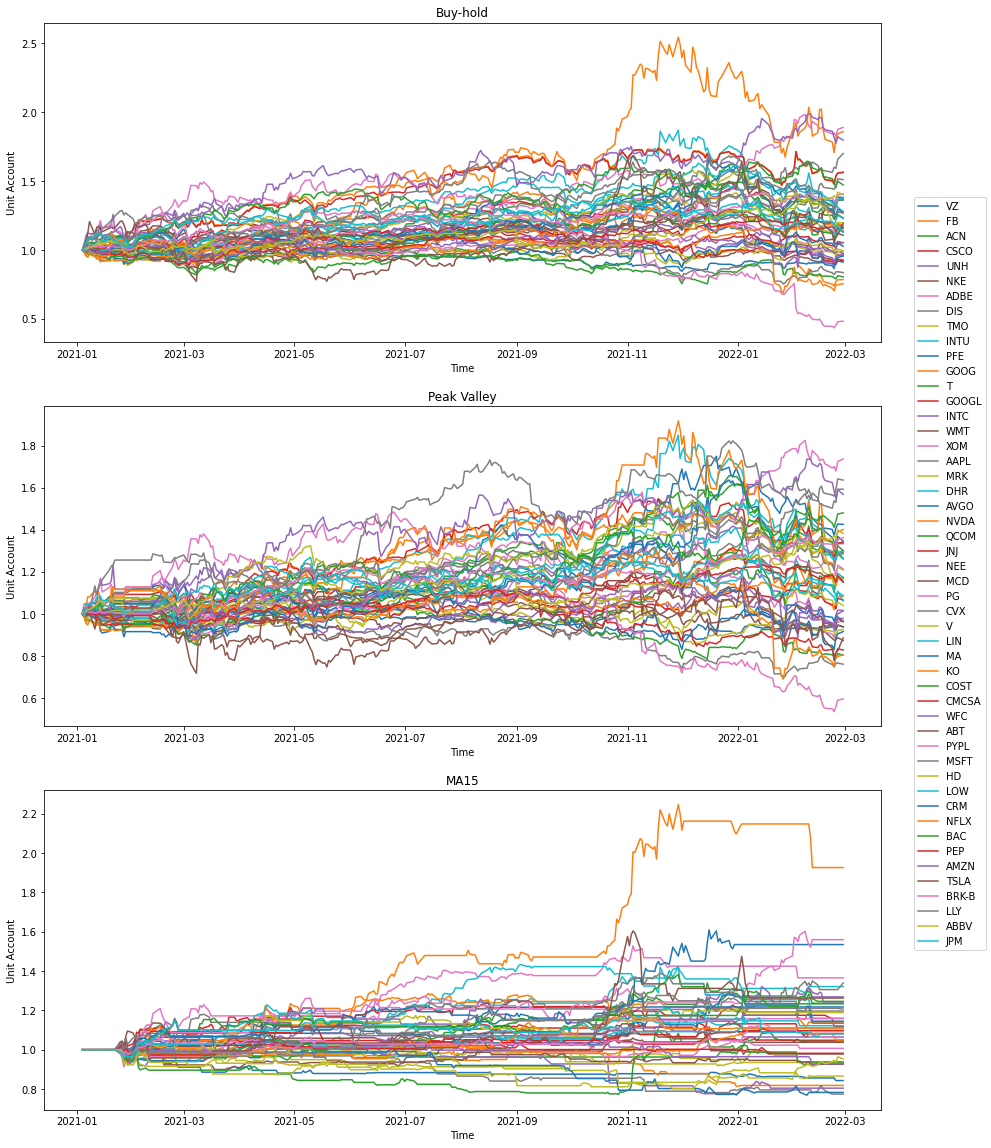

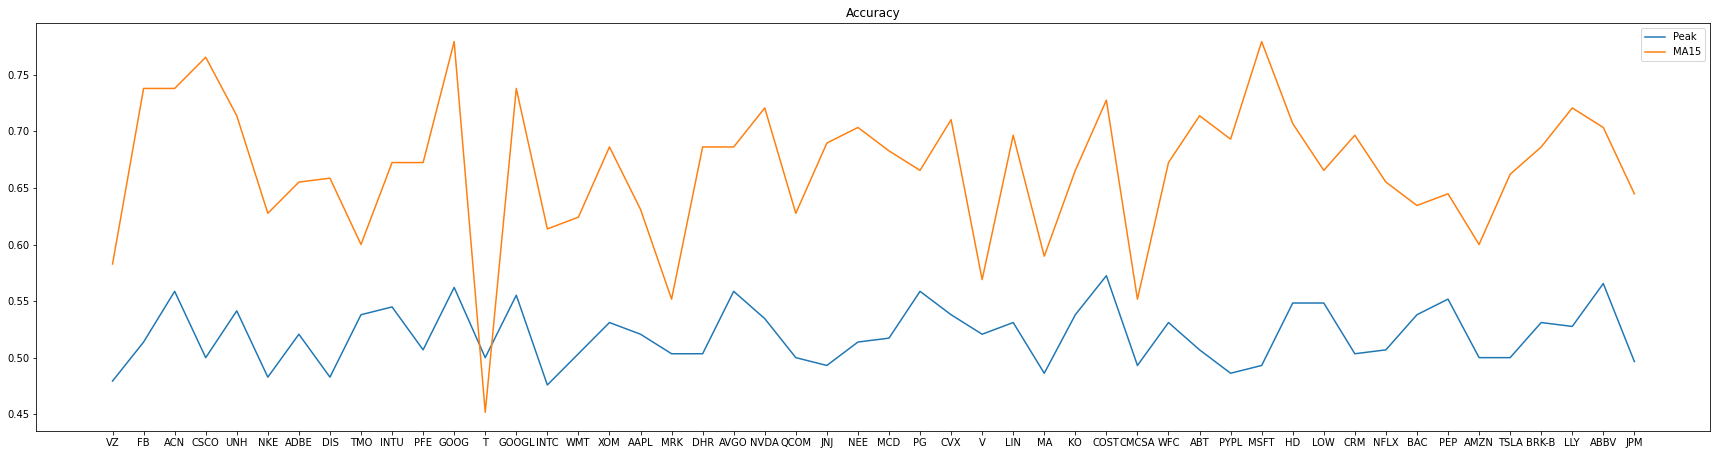

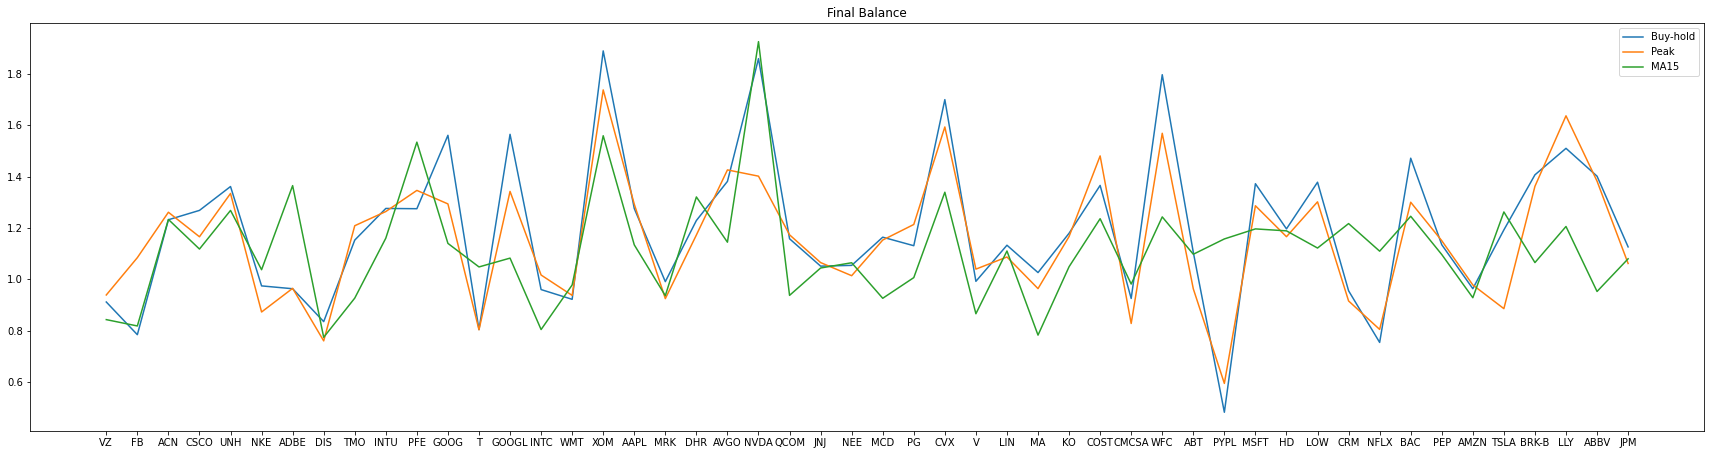

In [12]:
import glob
csvs = glob.glob('stock_data/training_data/*.csv')
symbols = []
accuracy = np.zeros((len(csvs), 2))
final_bal = np.zeros((len(csvs), 3))
acc_peak_cnt = 0
acc_MA15_cnt = 0
acct_peak_cnt = 0
acct_MA15_cnt = 0
ind = 0
fig, (axB, axP, axM) = plt.subplots(3,1, figsize=(15,20))
axB.set_title("Buy-hold")
axB.set_xlabel("Time")
axB.set_ylabel("Unit Account")
axP.set_title("Peak Valley")
axP.set_xlabel("Time")
axP.set_ylabel("Unit Account")
axM.set_title("MA15")
axM.set_xlabel("Time")
axM.set_ylabel("Unit Account")

linSVC_peak = LinearSVC()
model_peak = linSVC_peak.fit(comb_train_data, comb_train_labels_peak, sample_weight=1e-4)
linSVC_MA15 = LinearSVC()
model_MA15 = linSVC_MA15.fit(comb_train_data, comb_train_labels_MA15, sample_weight=1e-4)

for csv in csvs:
  symbol = csv[csv.rindex('/') + 1:-4]
  # Get stock test data features and labels
  test_dates, test_vals = pull_data_from_csv(symbol, "test_data")
  test_data = get_features_data(test_vals)
  test_labels_peak, _ = daily_peak_valley_labels(test_vals)
  test_labels_MA15, _ = MA15_trend_analysis_labels(test_vals)
  test_data[np.isnan(test_data)] = 0

  # Buy-hold
  buy_hold = np.ones((len(test_labels_peak),))
  buy_hold_acct = simulate(test_vals, buy_hold)
  axB.plot(test_dates, buy_hold_acct, label=symbol)

  # Train with Gaussian NB
  preds_peak = linSVC_peak.predict(test_data)
  acc_peak = metrics.accuracy_score(test_labels_peak, preds_peak)
  print(symbol, "Peak Valley Accuracy:", acc_peak)
  acct_peak = simulate(test_vals, preds_peak)
  print(symbol, "Peak Valley Final Balance: ", acct_peak[-1])

  preds_MA15 = linSVC_MA15.predict(test_data)
  acc_MA15 = metrics.accuracy_score(test_labels_MA15, preds_MA15)
  print(symbol, "MA15 Accuracy:", acc_MA15)
  acct_MA15 = simulate(test_vals, preds_MA15)
  print(symbol, "MA15 Final Balance: ", acct_MA15[-1])

  # Plot Account
  axP.plot(test_dates, acct_peak, label=symbol)
  axM.plot(test_dates, acct_MA15, label=symbol)

  # Update variables
  symbols.append(symbol)
  accuracy[ind,0] = acc_peak
  accuracy[ind,1] = acc_MA15
  final_bal[ind, 0] = acct_peak[-1]
  final_bal[ind, 1] = acct_MA15[-1]
  final_bal[ind, 2] = buy_hold_acct[-1]
  ind += 1
  acc_peak_cnt += acc_peak > acc_MA15
  acc_MA15_cnt += acc_MA15 > acc_peak
  acct_peak_cnt += acct_peak[-1] > acct_MA15[-1]
  acct_MA15_cnt += acct_MA15[-1] > acct_peak[-1]
fig.legend([axB, axP, axM], labels=symbols, loc="center right")

print("Higher Peak Accuracy Count: ", acc_peak_cnt)
print("Higher MA15 Accuracy Count: ", acc_MA15_cnt)
print("Higher Peak Final Balance Count: ", acct_peak_cnt)
print("Higher MA15 Final Balance Count: ", acct_MA15_cnt)
print("Avg Accuracy: [Peak, MA15] = ", np.mean(accuracy, axis=0))
print("Avg Final Balance: [Peak, MA15] = ", np.mean(final_bal, axis=0))
plt.figure(figsize=(30,7.5))
plt.plot(symbols, accuracy[:,0], label='Peak')
plt.plot(symbols, accuracy[:,1], label='MA15')
plt.legend()
plt.title("Accuracy")
plt.show()
plt.figure(figsize=(30,7.5))
plt.plot(symbols, final_bal[:,2], label='Buy-hold')
plt.plot(symbols, final_bal[:,0], label='Peak')
plt.plot(symbols, final_bal[:,1], label='MA15')
plt.legend()
plt.title("Final Balance")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


7


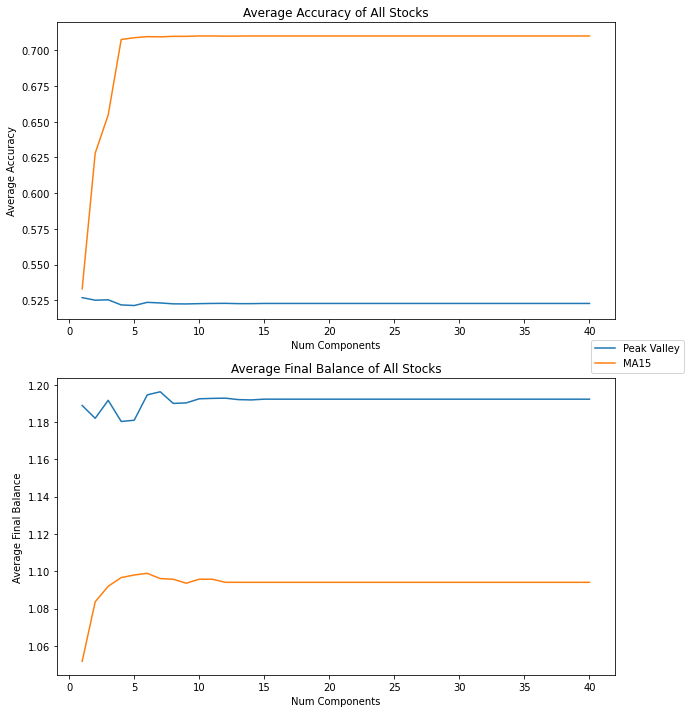

In [15]:
import glob
comp_list = list(range(1, 41))
peak_avg_accs = []
peak_avg_final_bal = []
MA15_avg_accs = []
MA15_avg_final_bal = []
csvs = glob.glob('stock_data/training_data/*.csv')
csvs.sort()
for i in comp_list:
  symbols = []
  accuracy = np.zeros((len(csvs), 2))
  final_bal = np.zeros((len(csvs), 2))
  acc_peak_cnt = 0
  acc_MA15_cnt = 0
  final_bal_peak_cnt = 0
  final_bal_MA15_cnt = 0
  ind = 0

  pca = PCA(n_components=i)
  comb_train_data_pca = pca.fit_transform(comb_train_data)
  linSVC_peak = LinearSVC()
  model_peak = linSVC_peak.fit(comb_train_data_pca, comb_train_labels_peak, sample_weight=1e-4)
  linSVC_MA15 = LinearSVC()
  model_MA15 = linSVC_MA15.fit(comb_train_data_pca, comb_train_labels_MA15, sample_weight=1e-4)
  for csv in csvs:
    symbol = csv[csv.rindex('/') + 1:-4]

    # Get stock test data features and labels
    test_dates, test_vals = pull_data_from_csv(symbol, "test_data")
    test_data = get_features_data(test_vals)
    test_labels_peak, _ = daily_peak_valley_labels(test_vals)
    test_labels_MA15, _ = MA15_trend_analysis_labels(test_vals)
    test_data[np.isnan(test_data)] = 0

    # Apply PCA to data
    test_data_pca = pca.transform(test_data)

    # Train with Gaussian NB
    preds_peak = linSVC_peak.predict(test_data_pca)
    acc_peak = metrics.accuracy_score(test_labels_peak, preds_peak)
    acct_peak = simulate(test_vals, preds_peak)

    preds_MA15 = linSVC_MA15.predict(test_data_pca)
    acc_MA15 = metrics.accuracy_score(test_labels_MA15, preds_MA15)
    acct_MA15 = simulate(test_vals, preds_MA15)

    # Update variables
    symbols.append(symbol)
    accuracy[ind,0] = acc_peak
    accuracy[ind,1] = acc_MA15
    final_bal[ind, 0] = acct_peak[-1]
    final_bal[ind, 1] = acct_MA15[-1]
    ind += 1
    acc_peak_cnt += acc_peak > acc_MA15
    acc_MA15_cnt += acc_MA15 > acc_peak
    final_bal_peak_cnt += acct_peak[-1] > acct_MA15[-1]
    final_bal_MA15_cnt += acct_MA15[-1] > acct_peak[-1]
  # print("Num Components:", i)
  # print("Higher Peak Accuracy Count: ", acc_peak_cnt)
  # print("Higher MA15 Accuracy Count: ", acc_MA15_cnt)
  # print("Higher Peak Final Balance Count: ", final_bal_peak_cnt)
  # print("Higher MA15 Final Balance Count: ", final_bal_MA15_cnt)
  avg_accuracy = np.mean(accuracy, axis=0)
  # print("Avg Accuracy: [Peak, MA15] = ", avg_accuracy)
  avg_final_bal = np.mean(final_bal, axis=0)
  # print("Avg Final Balance: [Peak, MA15] = ", avg_final_bal)
  peak_avg_accs.append(avg_accuracy[0])
  peak_avg_final_bal.append(avg_final_bal[0])
  MA15_avg_accs.append(avg_accuracy[1])
  MA15_avg_final_bal.append(avg_final_bal[1])
  # print()
fig, (ax_acc, ax_final_bal) = plt.subplots(2,1, figsize=(10,12))
ax_acc.plot(comp_list, peak_avg_accs, label="Peak Valley")
ax_acc.plot(comp_list, MA15_avg_accs, label="MA15")
ax_acc.set_title("Average Accuracy of All Stocks")
ax_acc.set_xlabel("Num Components")
ax_acc.set_ylabel("Average Accuracy")

ax_final_bal.plot(comp_list, peak_avg_final_bal, label="Peak Valley")
ax_final_bal.plot(comp_list, MA15_avg_final_bal, label="MA15")
ax_final_bal.set_title("Average Final Balance of All Stocks")
ax_final_bal.set_xlabel("Num Components")
ax_final_bal.set_ylabel("Average Final Balance")
fig.legend([ax_acc, ax_final_bal], labels=["Peak Valley", "MA15"], loc="center right")

print(np.argmax(peak_avg_final_bal)+1)  

PCA (7 components)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


Higher Peak Accuracy Count:  0
Higher MA15 Accuracy Count:  50
Higher Peak Final Balance Count:  34
Higher MA15 Final Balance Count:  16
Avg Accuracy: [Peak, MA15] =  [0.52310345 0.70951724]
Avg Final Balance: [Peak, MA15] =  [1.19625537 1.09608436 1.19225756]


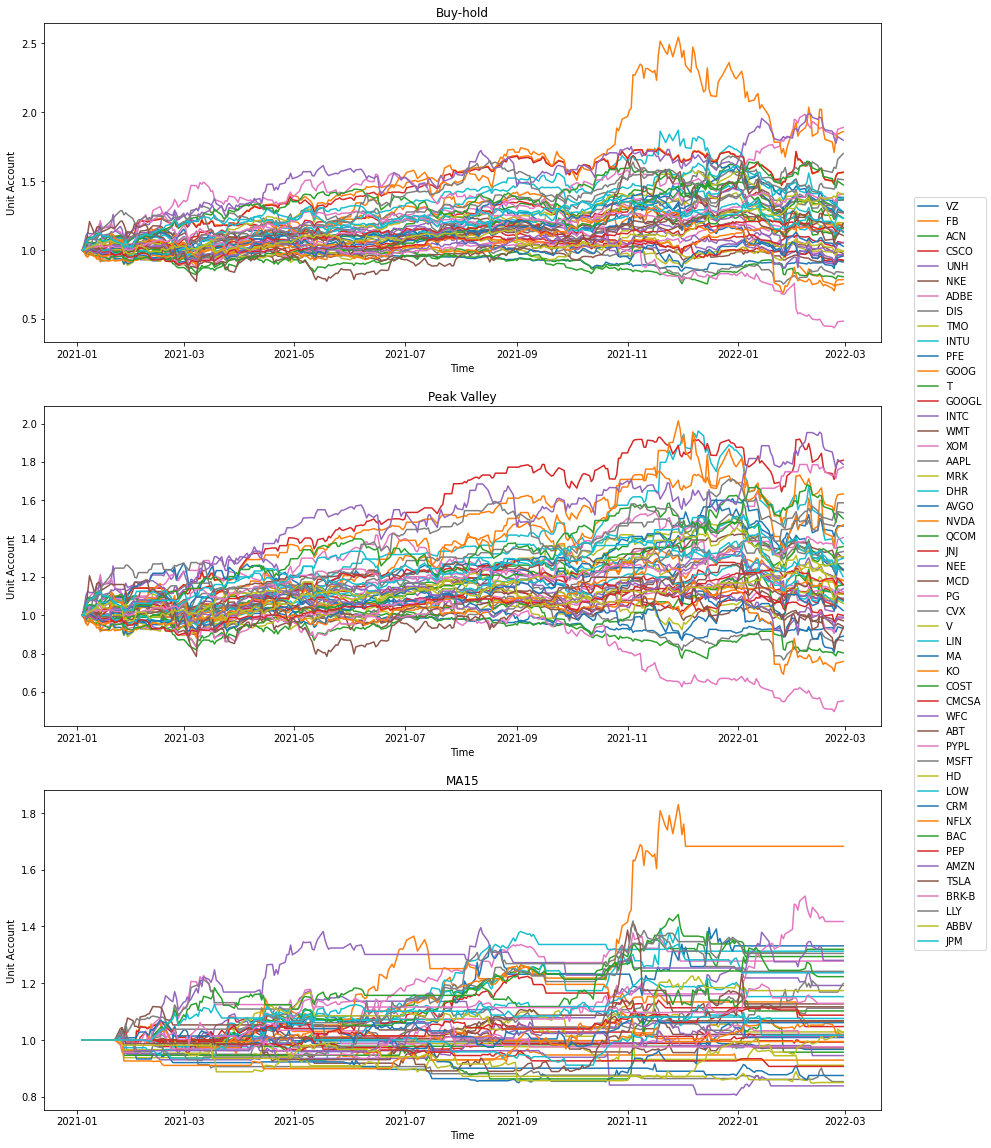

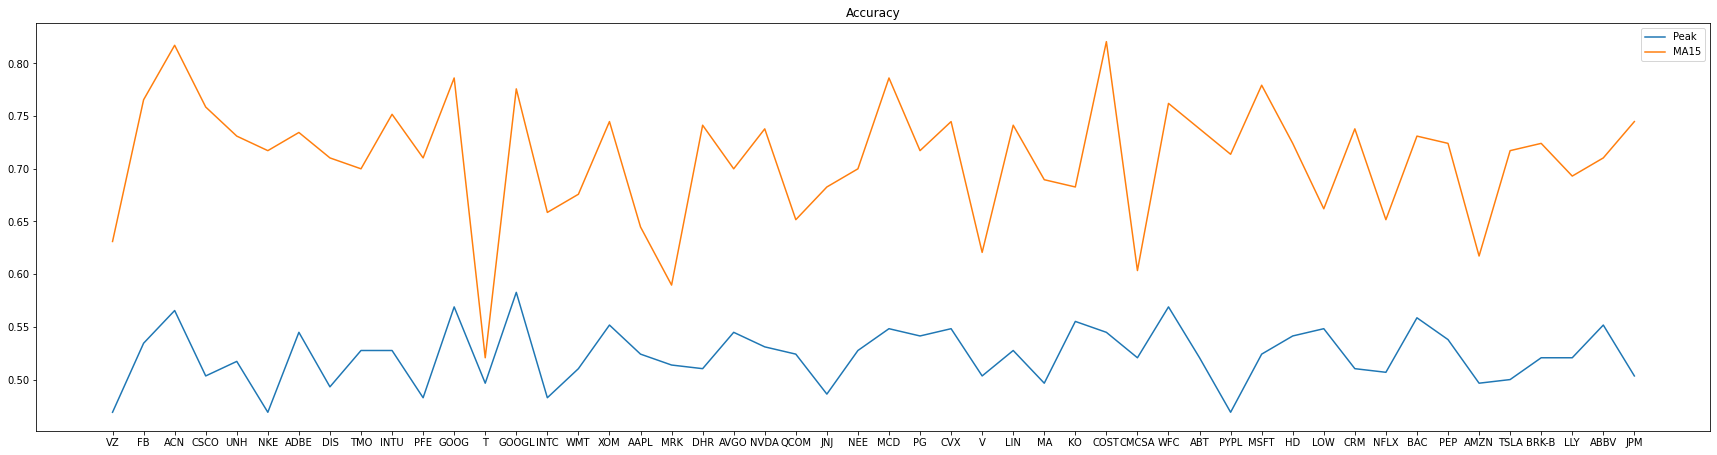

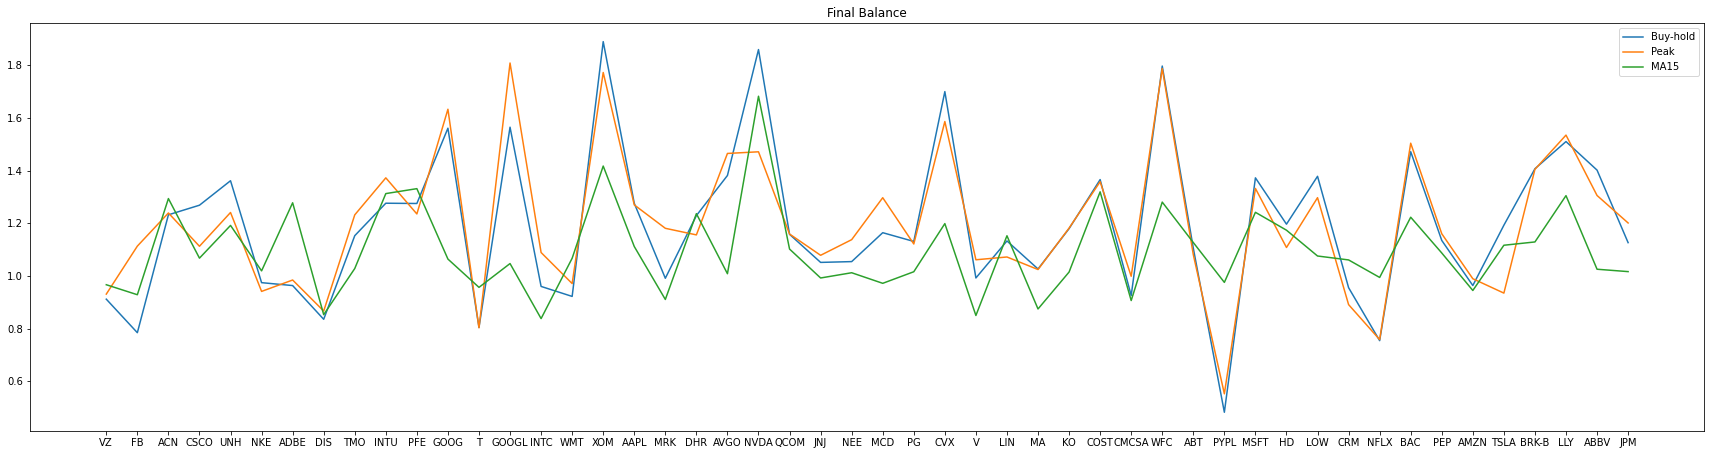

In [16]:
import glob
csvs = glob.glob('stock_data/training_data/*.csv')
symbols = []
accuracy = np.zeros((len(csvs), 2))
final_bal = np.zeros((len(csvs), 3))
acc_peak_cnt = 0
acc_MA15_cnt = 0
acct_peak_cnt = 0
acct_MA15_cnt = 0
ind = 0
fig, (axB, axP, axM) = plt.subplots(3,1, figsize=(15,20))
axB.set_title("Buy-hold")
axB.set_xlabel("Time")
axB.set_ylabel("Unit Account")
axP.set_title("Peak Valley")
axP.set_xlabel("Time")
axP.set_ylabel("Unit Account")
axM.set_title("MA15")
axM.set_xlabel("Time")
axM.set_ylabel("Unit Account")

pca = PCA(n_components=7)
comb_train_data_pca = pca.fit_transform(comb_train_data)
linSVC_peak = LinearSVC()
model_peak = linSVC_peak.fit(comb_train_data_pca, comb_train_labels_peak, sample_weight=1e-4)
linSVC_MA15 = LinearSVC()
model_MA15 = linSVC_MA15.fit(comb_train_data_pca, comb_train_labels_MA15, sample_weight=1e-4)

for csv in csvs:
  symbol = csv[csv.rindex('/') + 1:-4]
  # Get stock test data features and labels
  test_dates, test_vals = pull_data_from_csv(symbol, "test_data")
  test_data = get_features_data(test_vals)
  test_labels_peak, _ = daily_peak_valley_labels(test_vals)
  test_labels_MA15, _ = MA15_trend_analysis_labels(test_vals)
  test_data[np.isnan(test_data)] = 0

  # Apply PCA to data
  test_data_pca = pca.transform(test_data)

  # Buy-hold
  buy_hold = np.ones((len(test_labels_peak),))
  buy_hold_acct = simulate(test_vals, buy_hold)
  axB.plot(test_dates, buy_hold_acct, label=symbol)

  # Train with Gaussian NB
  preds_peak = linSVC_peak.predict(test_data_pca)
  acc_peak = metrics.accuracy_score(test_labels_peak, preds_peak)
  # print(symbol, "Peak Valley Accuracy:", acc_peak)
  acct_peak = simulate(test_vals, preds_peak)
  # print(symbol, "Peak Valley Final Balance: ", acct_peak[-1])

  preds_MA15 = linSVC_MA15.predict(test_data_pca)
  acc_MA15 = metrics.accuracy_score(test_labels_MA15, preds_MA15)
  # print(symbol, "MA15 Accuracy:", acc_MA15)
  acct_MA15 = simulate(test_vals, preds_MA15)
  # print(symbol, "MA15 Final Balance: ", acct_MA15[-1])

  # Plot Account
  axP.plot(test_dates, acct_peak, label=symbol)
  axM.plot(test_dates, acct_MA15, label=symbol)

  # Update variables
  symbols.append(symbol)
  accuracy[ind,0] = acc_peak
  accuracy[ind,1] = acc_MA15
  final_bal[ind, 0] = acct_peak[-1]
  final_bal[ind, 1] = acct_MA15[-1]
  final_bal[ind, 2] = buy_hold_acct[-1]
  ind += 1
  acc_peak_cnt += acc_peak > acc_MA15
  acc_MA15_cnt += acc_MA15 > acc_peak
  acct_peak_cnt += acct_peak[-1] > acct_MA15[-1]
  acct_MA15_cnt += acct_MA15[-1] > acct_peak[-1]
fig.legend([axB, axP, axM], labels=symbols, loc="center right")

print("Higher Peak Accuracy Count: ", acc_peak_cnt)
print("Higher MA15 Accuracy Count: ", acc_MA15_cnt)
print("Higher Peak Final Balance Count: ", acct_peak_cnt)
print("Higher MA15 Final Balance Count: ", acct_MA15_cnt)
print("Avg Accuracy: [Peak, MA15] = ", np.mean(accuracy, axis=0))
print("Avg Final Balance: [Peak, MA15] = ", np.mean(final_bal, axis=0))
plt.figure(figsize=(30,7.5))
plt.plot(symbols, accuracy[:,0], label='Peak')
plt.plot(symbols, accuracy[:,1], label='MA15')
plt.legend()
plt.title("Accuracy")
plt.show()
plt.figure(figsize=(30,7.5))
plt.plot(symbols, final_bal[:,2], label='Buy-hold')
plt.plot(symbols, final_bal[:,0], label='Peak')
plt.plot(symbols, final_bal[:,1], label='MA15')
plt.legend()
plt.title("Final Balance")
plt.show()

In [18]:
pca = PCA(n_components=7)
comb_train_data_pca = pca.fit_transform(comb_train_data)
for i in range(7):
    print(i, np.where(np.abs(pca.components_[i,:]) > 0.1))

0 (array([22, 23, 24, 25, 26]),)
1 (array([22, 23, 24, 25, 26]),)
2 (array([22, 23, 25, 26]),)
3 (array([22, 24, 25, 26]),)
4 (array([23, 24, 25, 26]),)
5 (array([32]),)
6 (array([ 3,  4,  7,  9, 10, 11, 12, 13, 15, 16, 17, 21, 37, 38]),)


In [19]:
clusters = [['MA', 'AMZN', 'NEE', 'DHR', 'GOOG', 'UNH', 'MSFT', 'ACN', 'V', 'HD', 'COST', 'NKE', 'CRM', 'AVGO', 'AAPL', 'LOW', 'LLY', 'TMO', 'GOOGL'],
            ['CVX', 'KO', 'WFC'],
            ['BAC', 'ABT', 'ABBV', 'MCD', 'DIS', 'INTC', 'CSCO', 'JPM', 'CMCSA', 'QCOM', 'BRK-B', 'LIN'],
            ['XOM', 'T', 'VZ'],
            ['JNJ', 'PG', 'PFE', 'PEP', 'WMT', 'MRK'],
            ['TSLA', 'FB', 'NVDA', 'ADBE', 'INTU', 'NFLX']]
cluster_train_data = []
cluster_train_labels_peak = []
cluster_train_labels_MA15 = []

for stock_list in clusters:
    comb_train_data = np.array([]).reshape(0,40)
    comb_train_labels_peak = np.array([]).reshape(0,1)
    comb_train_labels_MA15 = np.array([]).reshape(0,1)
    for symbol in stock_list:
        # Get stock training data features and labels
        train_dates, train_vals = pull_data_from_csv(symbol, "training_data")
        train_data = get_features_data(train_vals)
        train_labels_peak, _ = daily_peak_valley_labels(train_vals)
        train_labels_MA15, _ = MA15_trend_analysis_labels(train_vals)
        train_data[np.isnan(train_data)] = 0
        comb_train_data = np.vstack((comb_train_data, train_data))
        comb_train_labels_peak = np.vstack((comb_train_labels_peak, np.reshape(train_labels_peak, (len(train_labels_peak), 1))))
        comb_train_labels_MA15 = np.vstack((comb_train_labels_MA15, np.reshape(train_labels_MA15, (len(train_labels_MA15), 1))))
    comb_train_labels_peak = comb_train_labels_peak.ravel()
    comb_train_labels_MA15 = comb_train_labels_MA15.ravel()
    cluster_train_data.append(comb_train_data)
    cluster_train_labels_peak.append(comb_train_labels_peak)
    cluster_train_labels_MA15.append(comb_train_labels_MA15)

Cluster  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


Higher Peak Accuracy Count:  1
Higher MA15 Accuracy Count:  18
Higher Peak Final Balance Count:  15
Higher MA15 Final Balance Count:  4
Avg Accuracy: [Peak, MA15] =  [0.5292196  0.62740472]
Avg Final Balance: [Peak, MA15, Buy-hold] =  [1.23337716 1.13144514 1.23951547]


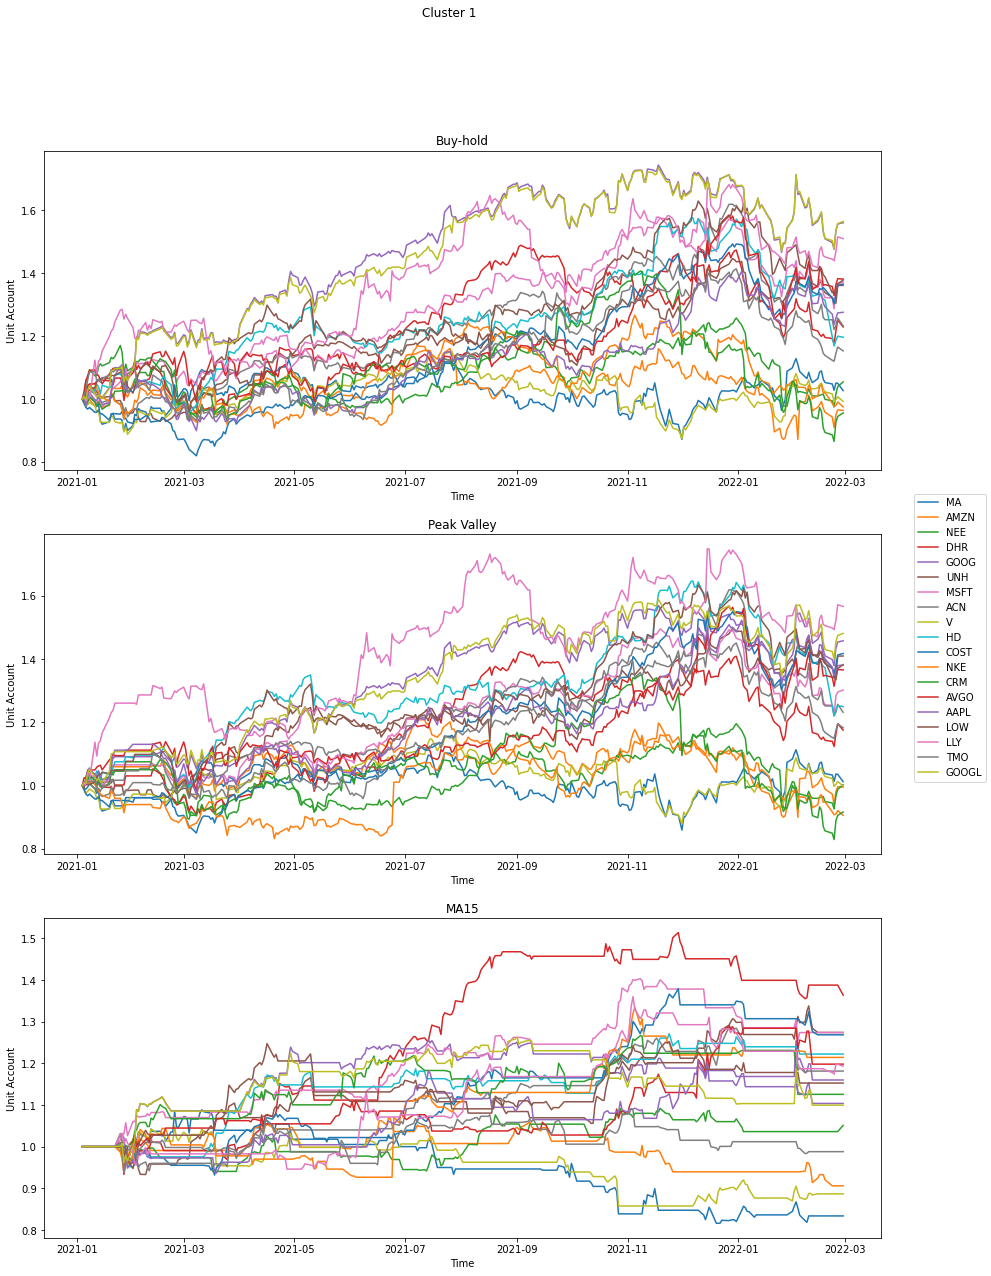

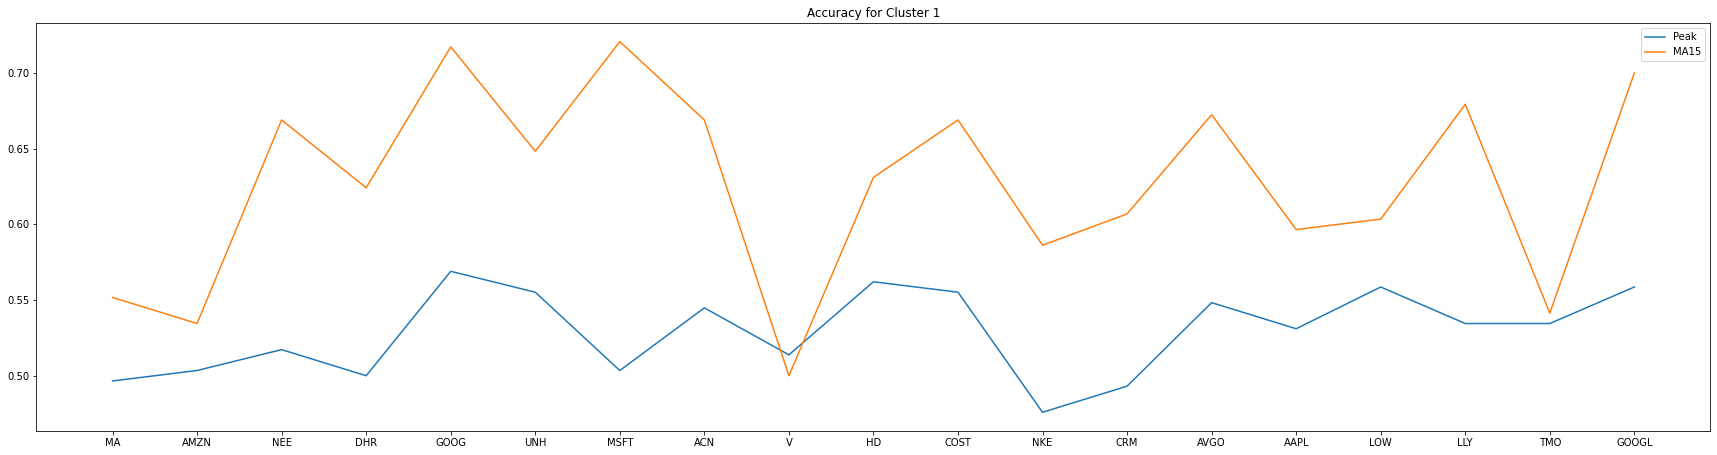

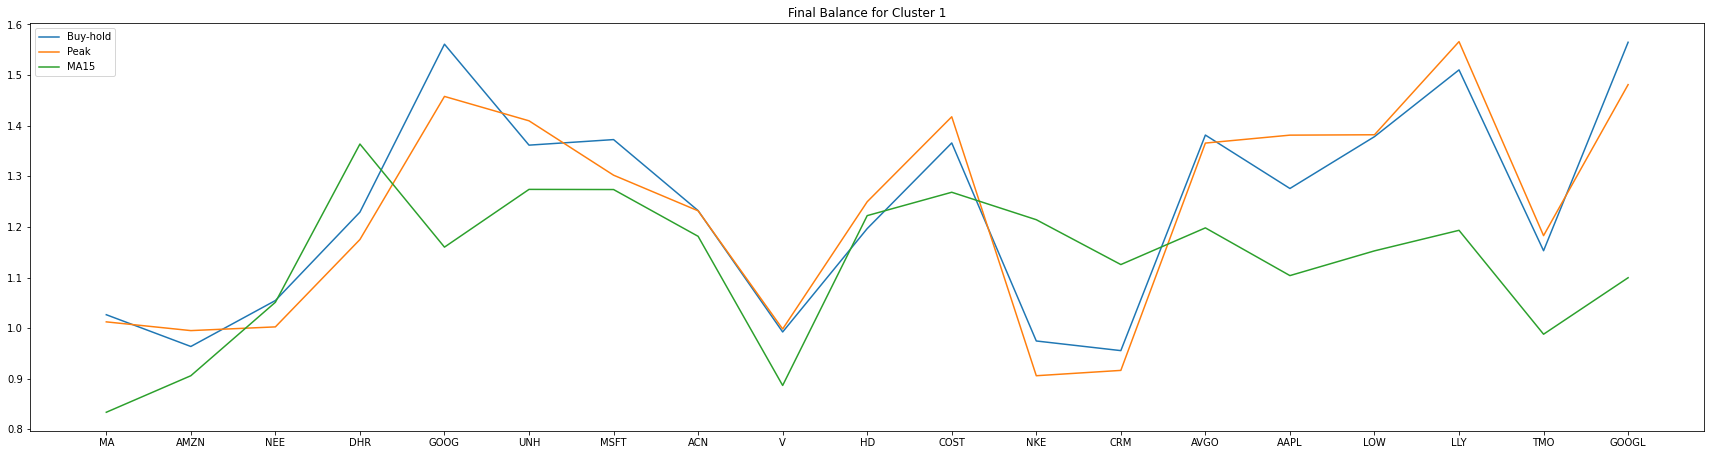

Cluster  2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


Higher Peak Accuracy Count:  0
Higher MA15 Accuracy Count:  3
Higher Peak Final Balance Count:  2
Higher MA15 Final Balance Count:  1
Avg Accuracy: [Peak, MA15] =  [0.52068966 0.57241379]
Avg Final Balance: [Peak, MA15, Buy-hold] =  [1.32047857 1.13385667 1.55885621]


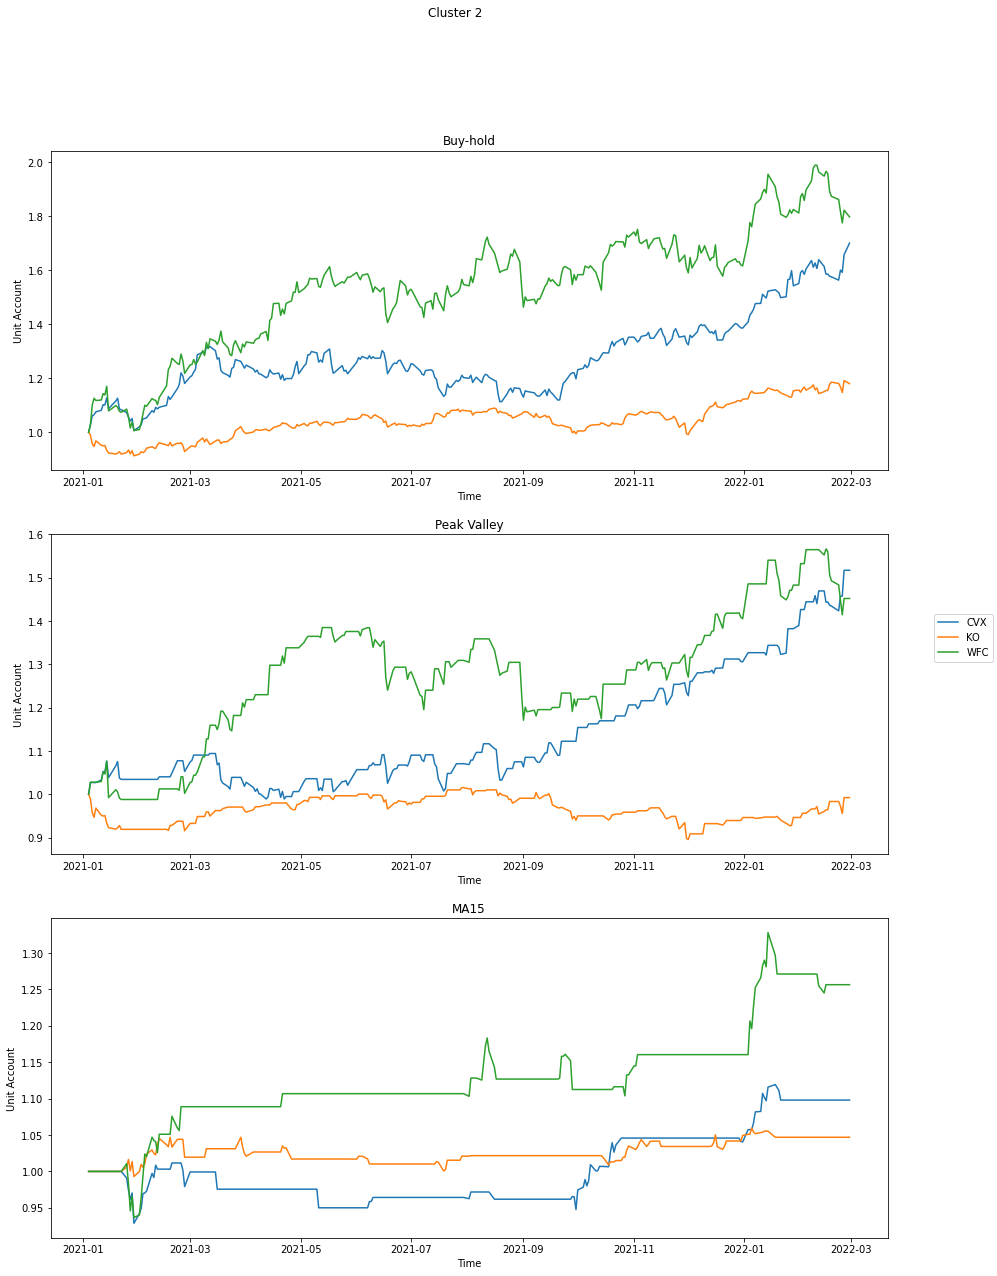

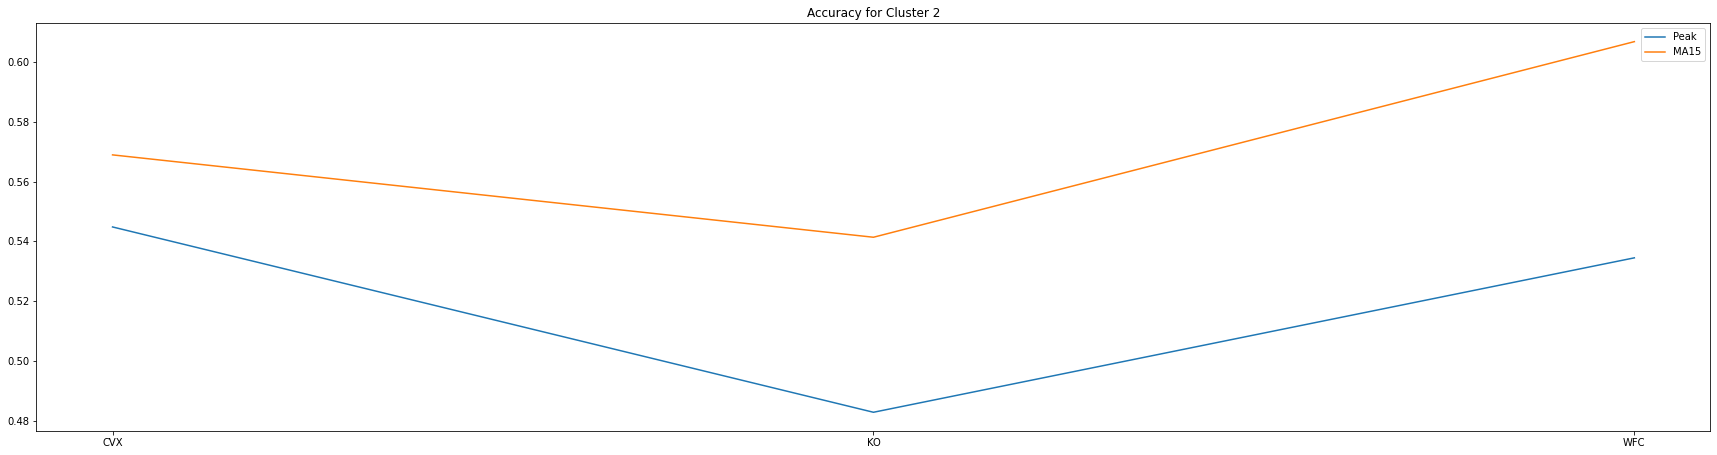

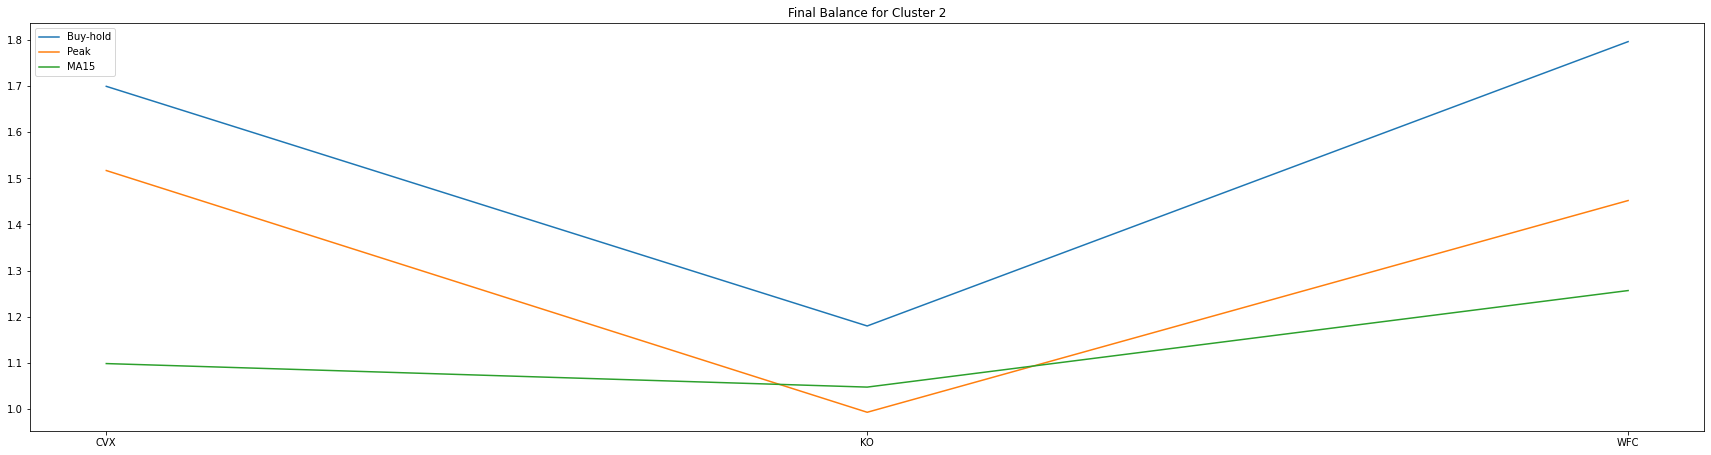

Cluster  3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


Higher Peak Accuracy Count:  0
Higher MA15 Accuracy Count:  12
Higher Peak Final Balance Count:  7
Higher MA15 Final Balance Count:  5
Avg Accuracy: [Peak, MA15] =  [0.51178161 0.6112069 ]
Avg Final Balance: [Peak, MA15, Buy-hold] =  [1.11405299 1.02684537 1.16322689]


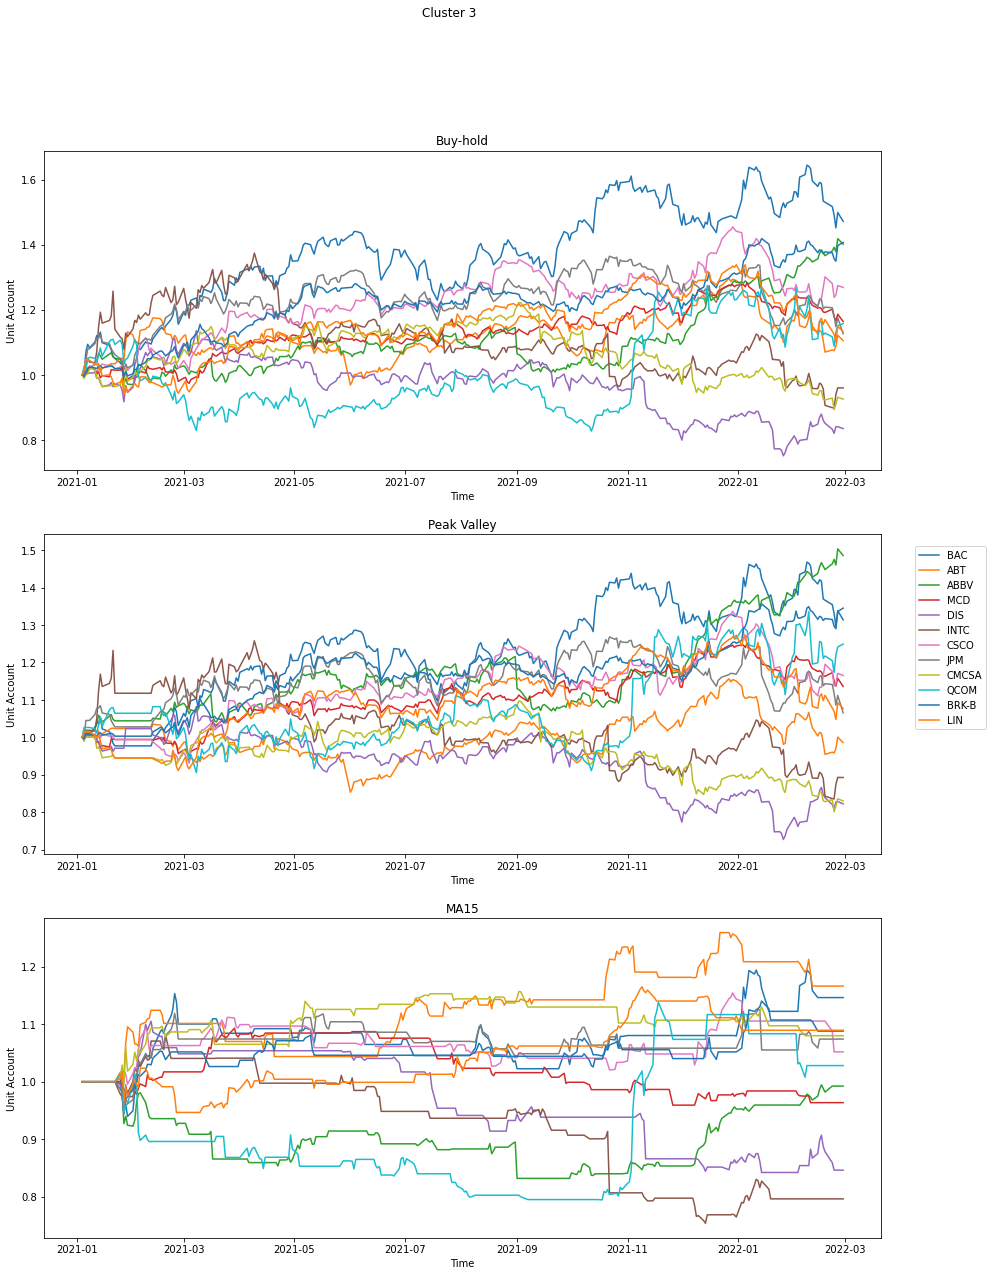

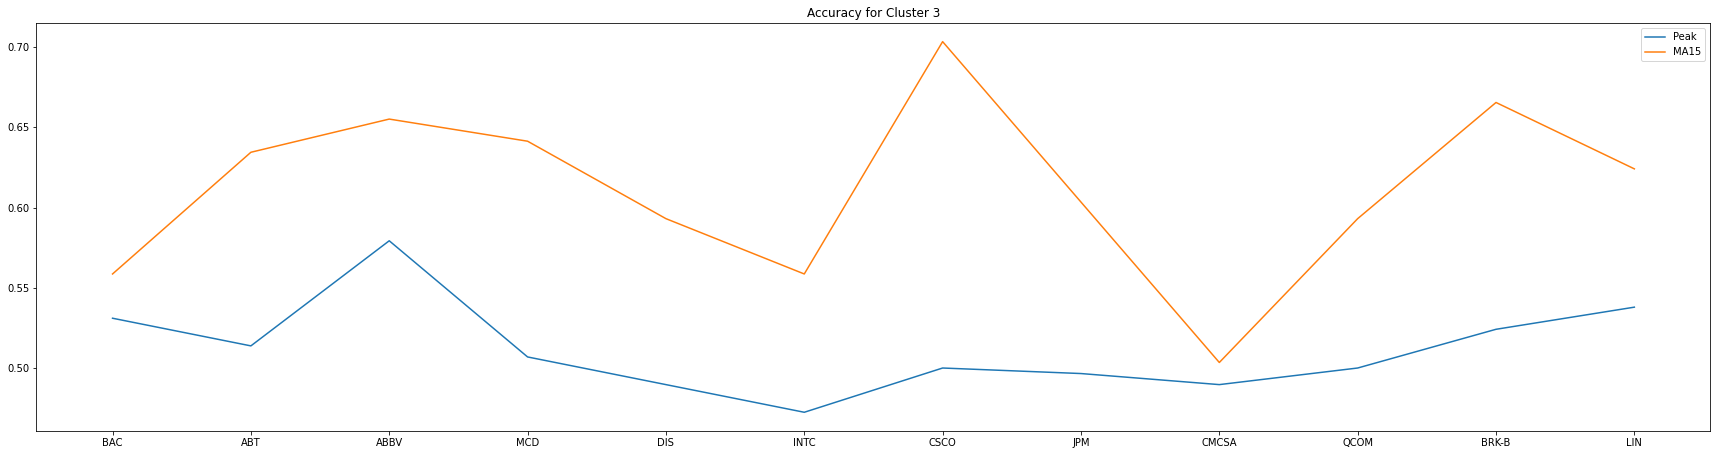

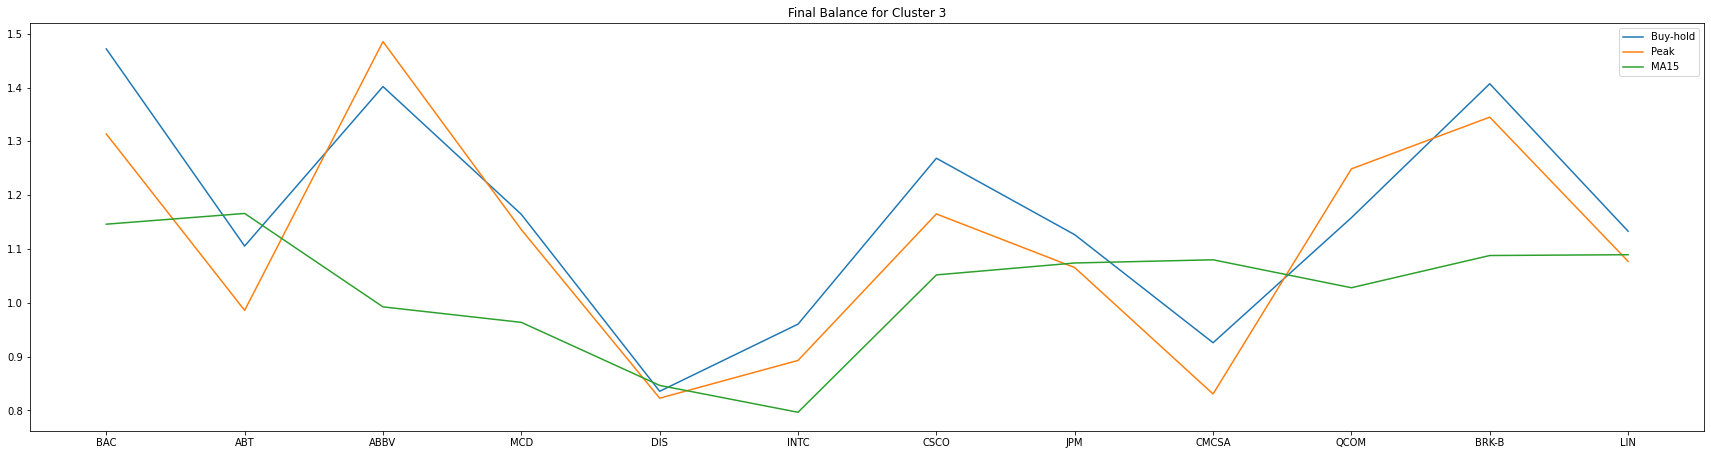

Cluster  4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


Higher Peak Accuracy Count:  2
Higher MA15 Accuracy Count:  1
Higher Peak Final Balance Count:  2
Higher MA15 Final Balance Count:  1
Avg Accuracy: [Peak, MA15] =  [0.52643678 0.52873563]
Avg Final Balance: [Peak, MA15, Buy-hold] =  [1.16311798 1.07816863 1.20210187]


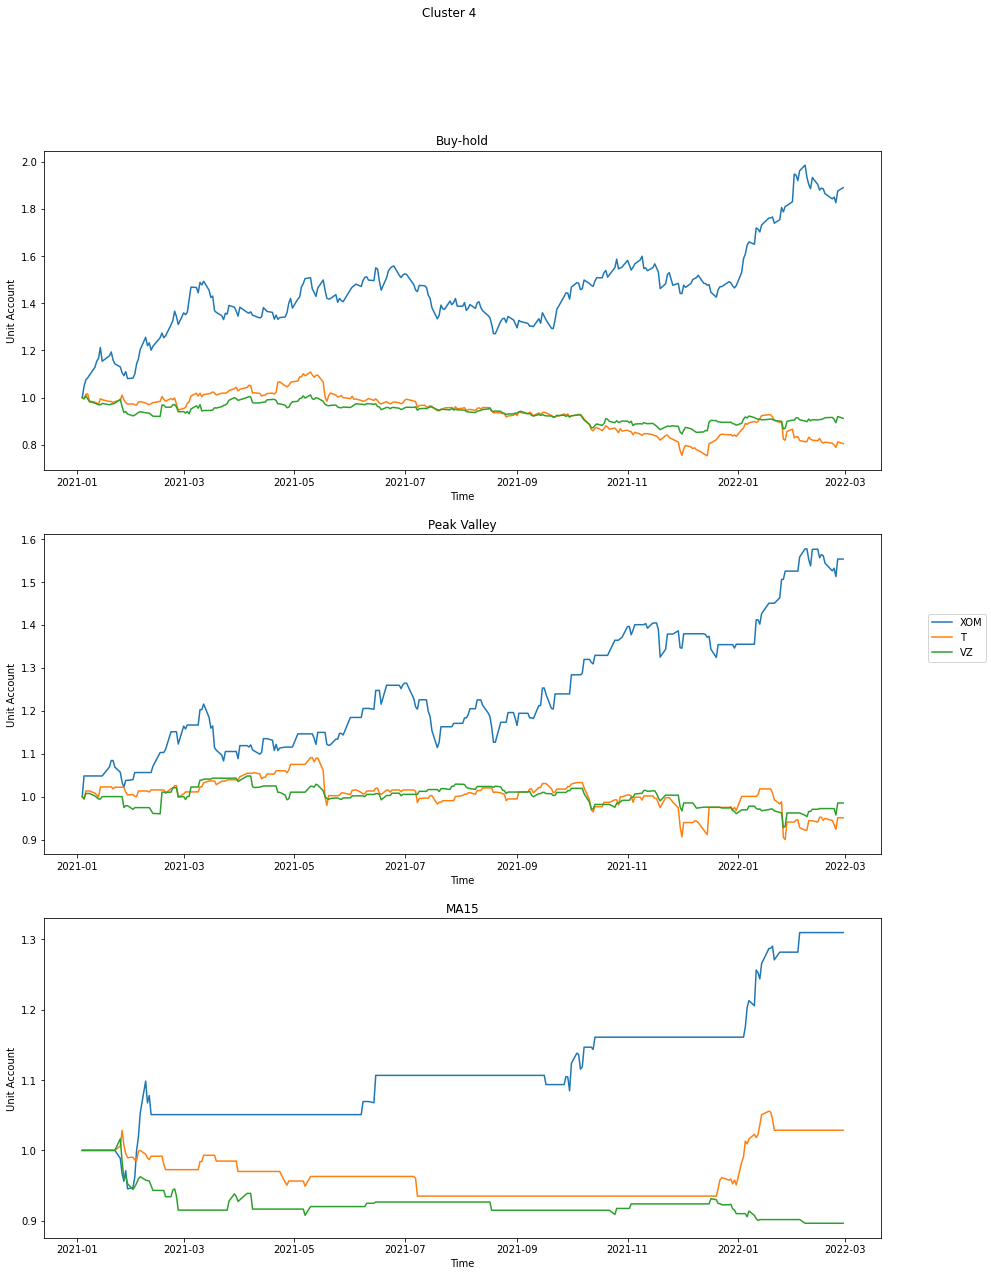

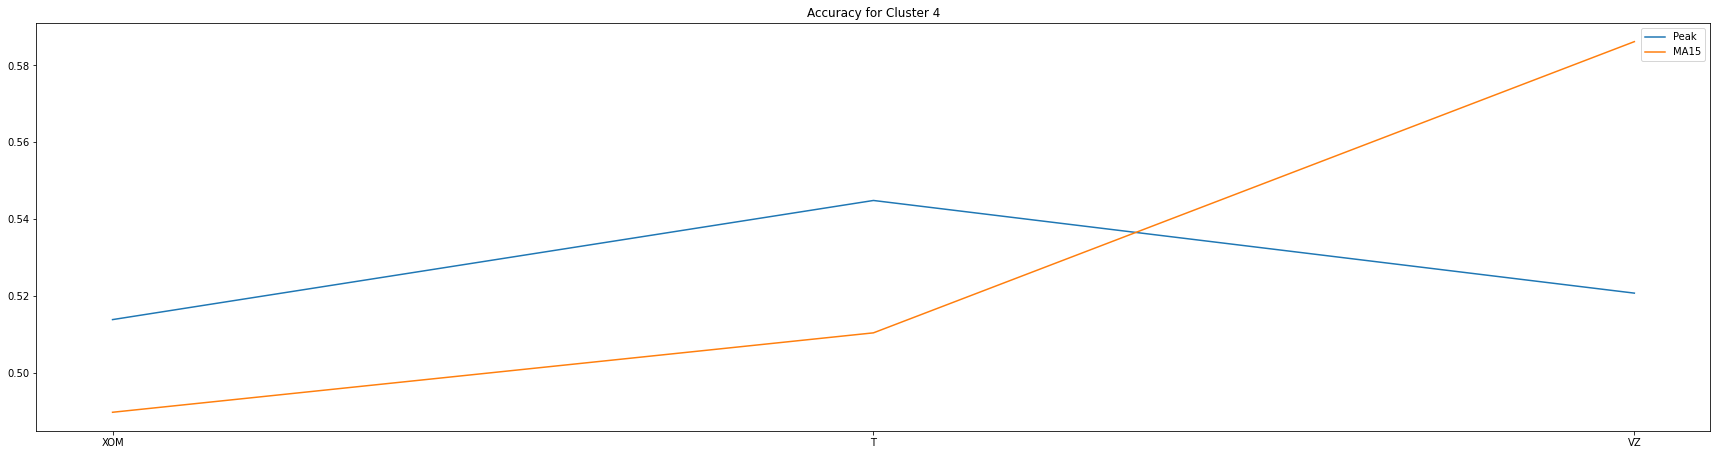

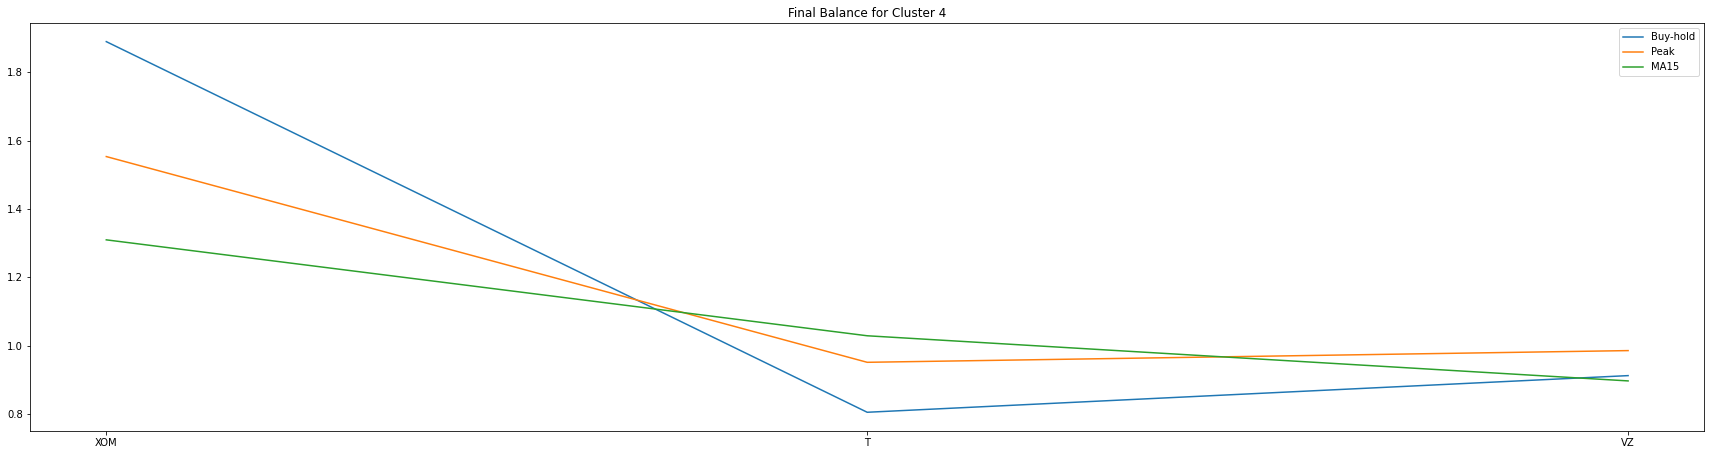

Cluster  5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


Higher Peak Accuracy Count:  0
Higher MA15 Accuracy Count:  6
Higher Peak Final Balance Count:  2
Higher MA15 Final Balance Count:  4
Avg Accuracy: [Peak, MA15] =  [0.50747126 0.5816092 ]
Avg Final Balance: [Peak, MA15, Buy-hold] =  [1.08634277 1.10146504 1.08442302]


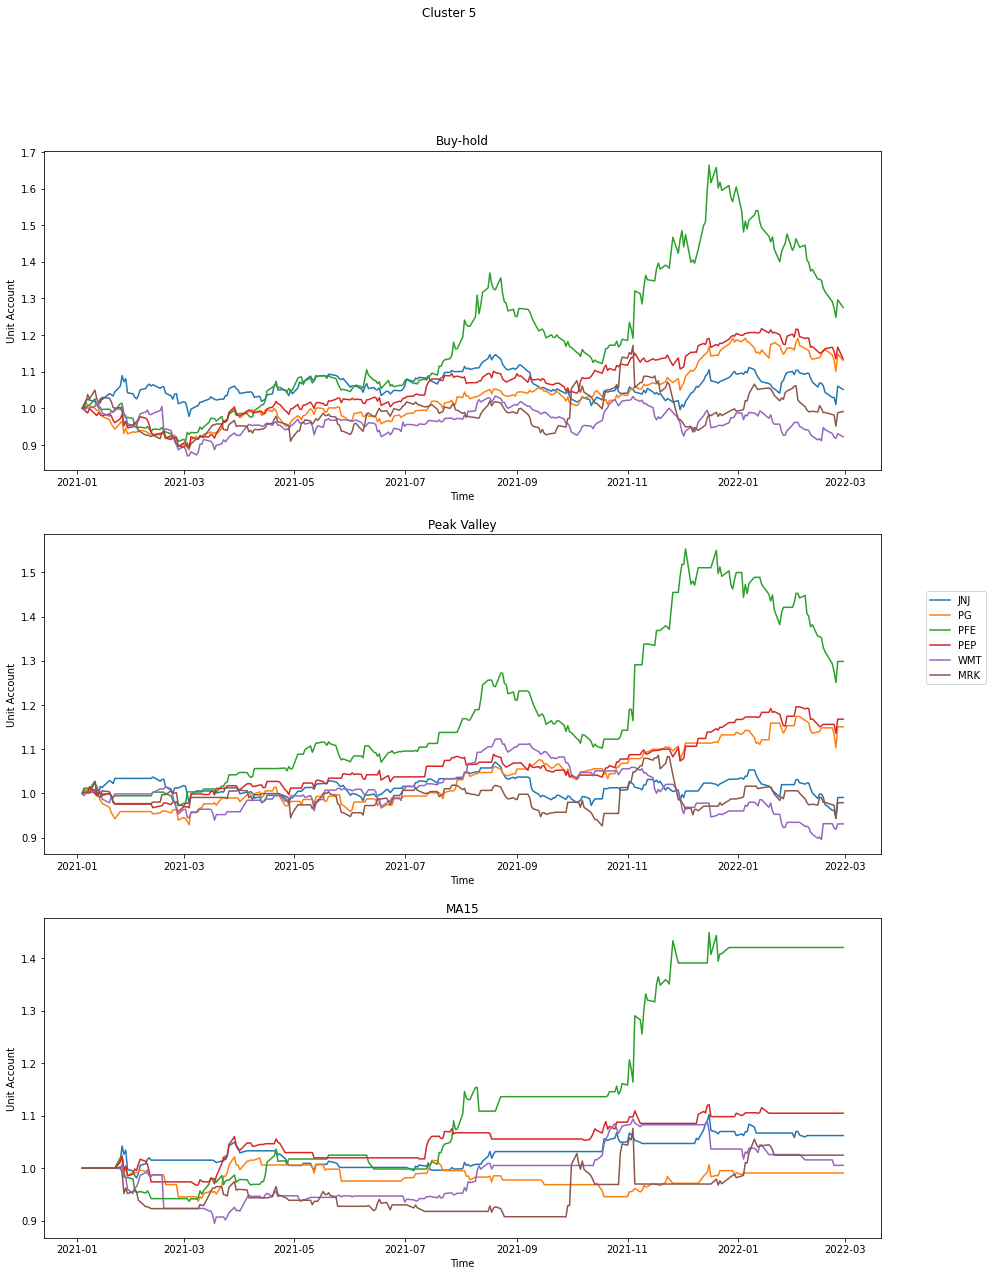

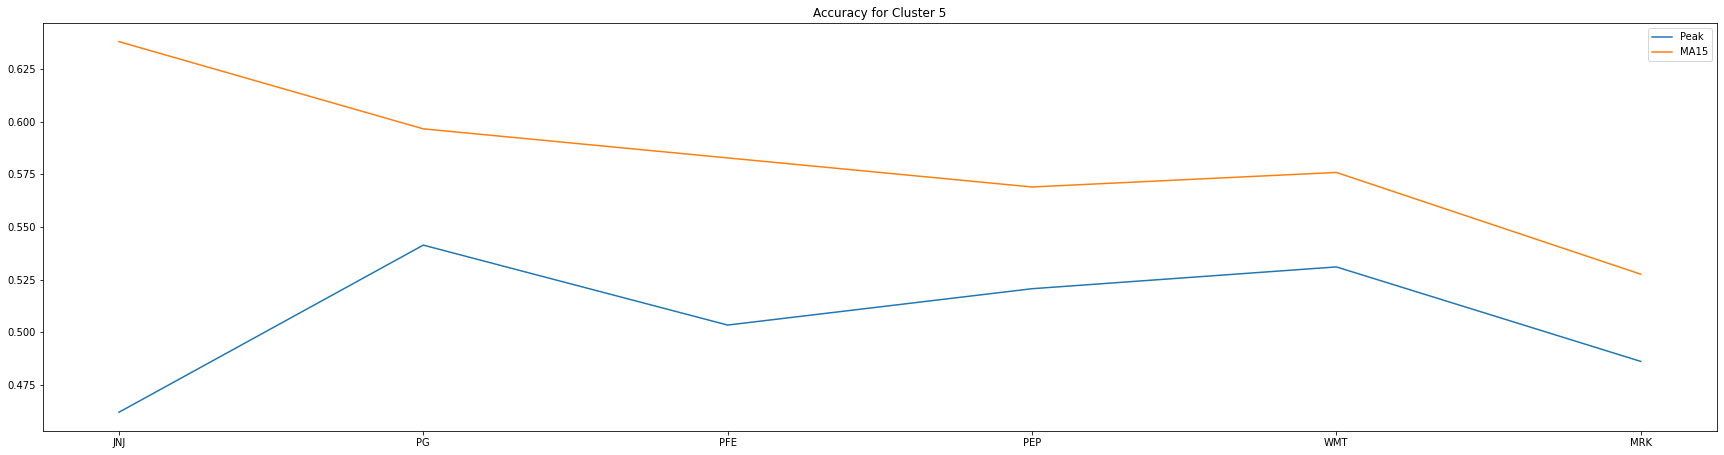

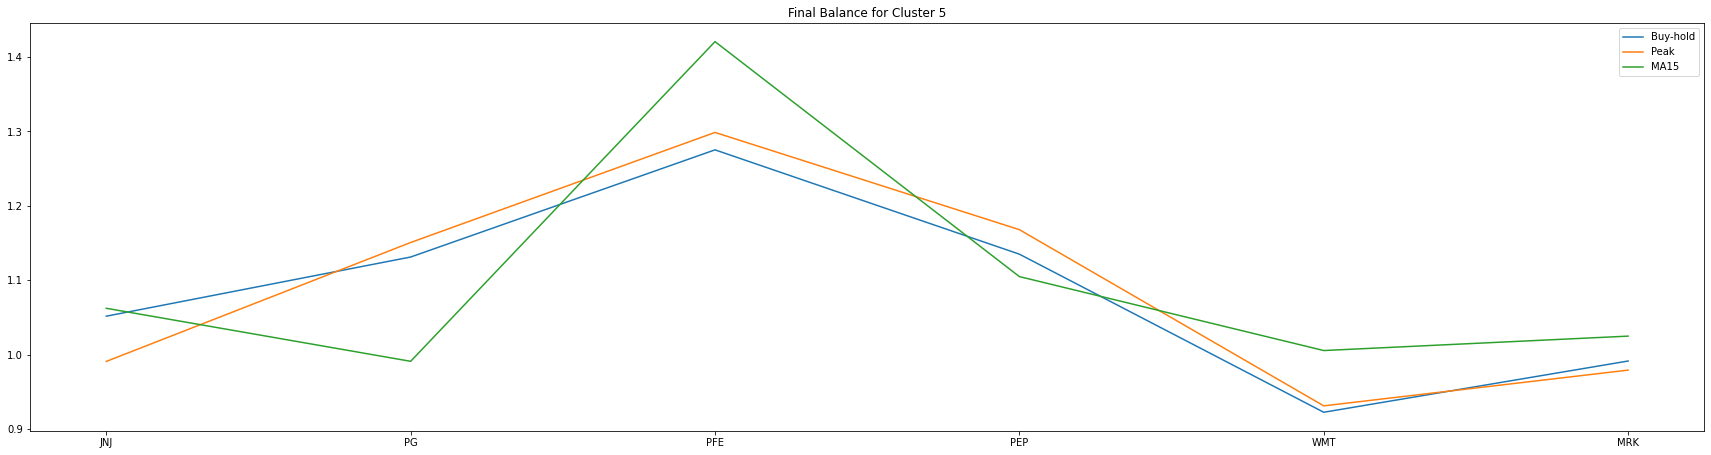

Cluster  6


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


Higher Peak Accuracy Count:  0
Higher MA15 Accuracy Count:  6
Higher Peak Final Balance Count:  1
Higher MA15 Final Balance Count:  5
Avg Accuracy: [Peak, MA15] =  [0.51609195 0.62068966]
Avg Final Balance: [Peak, MA15, Buy-hold] =  [1.13915151 1.20648756 1.13855429]


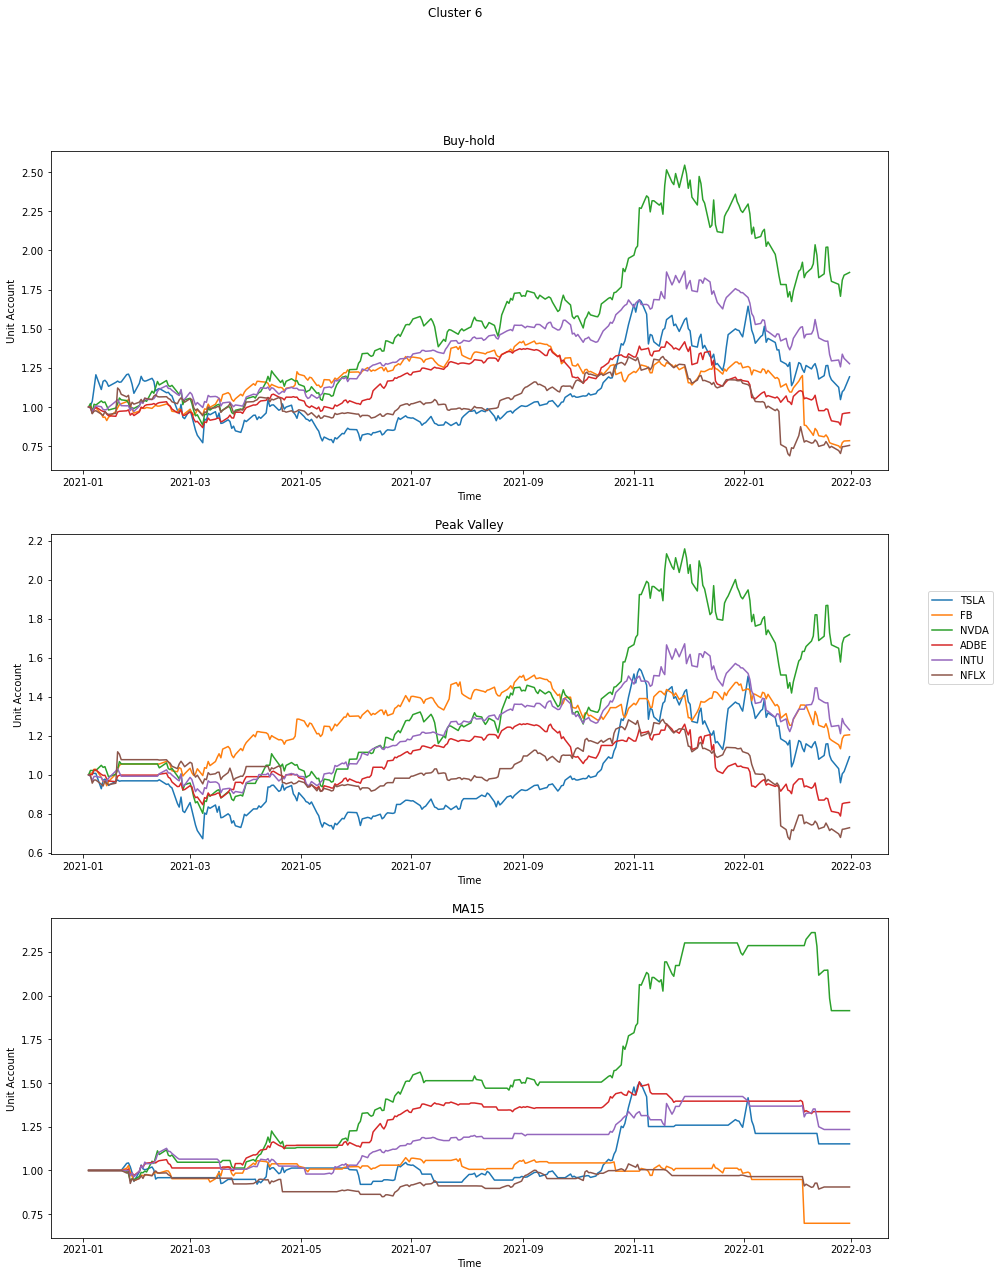

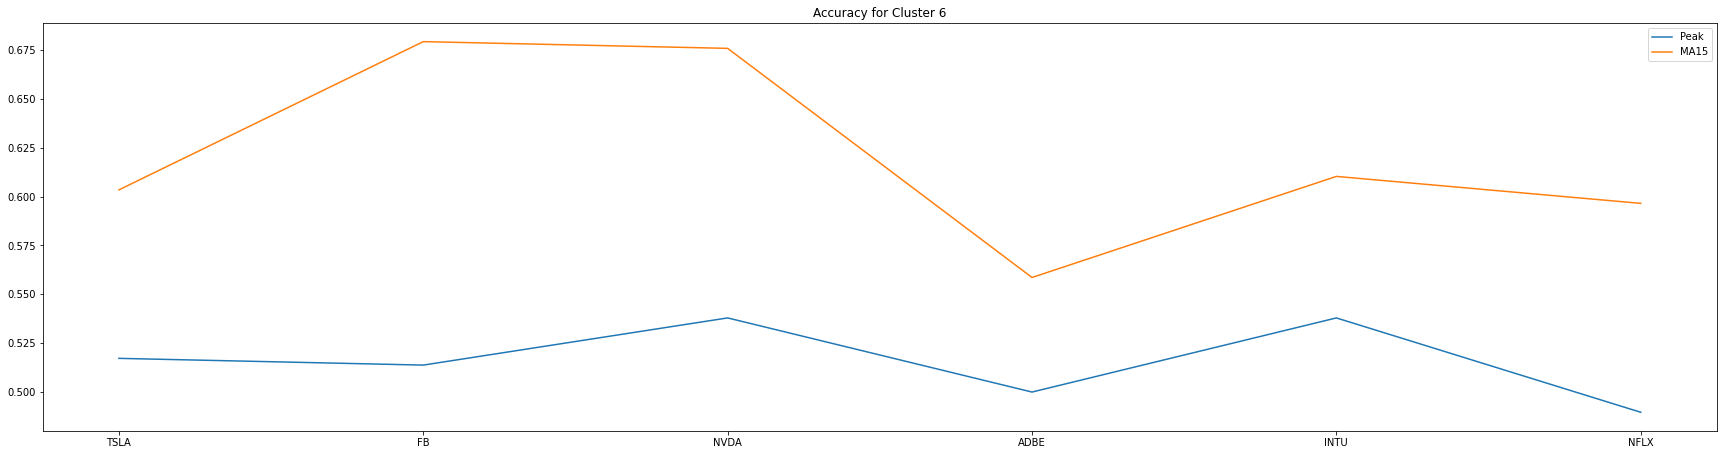

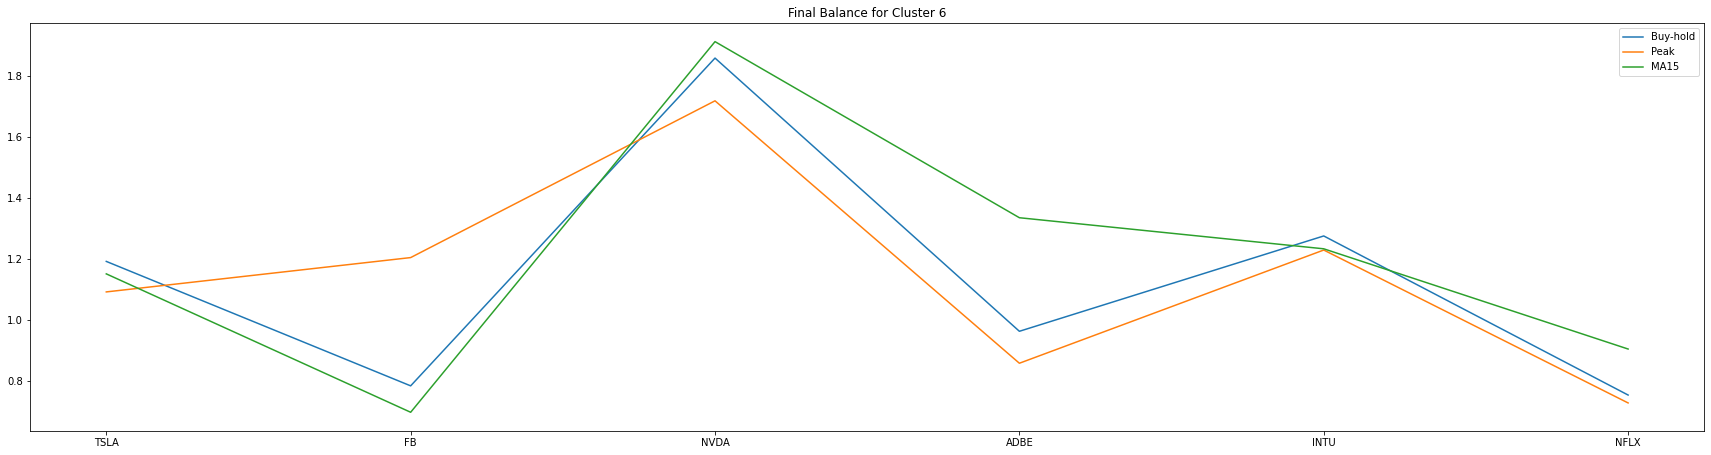

In [20]:
for i in range(len(clusters)):
    print("Cluster ", i+1)
    symbols = clusters[i]
    accuracy = np.zeros((len(symbols), 2))
    final_bal = np.zeros((len(symbols), 3))
    acc_peak_cnt = 0
    acc_MA15_cnt = 0
    acct_peak_cnt = 0
    acct_MA15_cnt = 0
    ind = 0
    fig, (axB, axP, axM) = plt.subplots(3,1, figsize=(15,20))
    fig.suptitle("Cluster {}".format(i+1))
    axB.set_title("Buy-hold")
    axB.set_xlabel("Time")
    axB.set_ylabel("Unit Account")
    axP.set_title("Peak Valley")
    axP.set_xlabel("Time")
    axP.set_ylabel("Unit Account")
    axM.set_title("MA15")
    axM.set_xlabel("Time")
    axM.set_ylabel("Unit Account")

    linSVC_peak = LinearSVC()
    model_peak = linSVC_peak.fit(cluster_train_data[i], cluster_train_labels_peak[i], sample_weight=1e-4)
    linSVC_MA15 = LinearSVC()
    model_MA15 = linSVC_MA15.fit(cluster_train_data[i], cluster_train_labels_MA15[i], sample_weight=1e-4)

    for symbol in symbols:
        # Get stock test data features and labels
        test_dates, test_vals = pull_data_from_csv(symbol, "test_data")
        test_data = get_features_data(test_vals)
        test_labels_peak, _ = daily_peak_valley_labels(test_vals)
        test_labels_MA15, _ = MA15_trend_analysis_labels(test_vals)
        test_data[np.isnan(test_data)] = 0

        # Buy-hold
        buy_hold = np.ones((len(test_labels_peak),))
        buy_hold_acct = simulate(test_vals, buy_hold)
        axB.plot(test_dates, buy_hold_acct, label=symbol)

        # Train with Gaussian NB
        preds_peak = linSVC_peak.predict(test_data)
        acc_peak = metrics.accuracy_score(test_labels_peak, preds_peak)
        # print(symbol, "Peak Valley Accuracy:", acc_peak)
        acct_peak = simulate(test_vals, preds_peak)
        # print(symbol, "Peak Valley Final Balance: ", acct_peak[-1])

        preds_MA15 = linSVC_MA15.predict(test_data)
        acc_MA15 = metrics.accuracy_score(test_labels_MA15, preds_MA15)
        # print(symbol, "MA15 Accuracy:", acc_MA15)
        acct_MA15 = simulate(test_vals, preds_MA15)
        # print(symbol, "MA15 Final Balance: ", acct_MA15[-1])

        # Plot Account
        axP.plot(test_dates, acct_peak, label=symbol)
        axM.plot(test_dates, acct_MA15, label=symbol)

        # Update variables
        accuracy[ind,0] = acc_peak
        accuracy[ind,1] = acc_MA15
        final_bal[ind, 0] = acct_peak[-1]
        final_bal[ind, 1] = acct_MA15[-1]
        final_bal[ind, 2] = buy_hold_acct[-1]
        ind += 1
        acc_peak_cnt += acc_peak > acc_MA15
        acc_MA15_cnt += acc_MA15 > acc_peak
        acct_peak_cnt += acct_peak[-1] > acct_MA15[-1]
        acct_MA15_cnt += acct_MA15[-1] > acct_peak[-1]

    fig.legend([axB, axP, axM], labels=symbols, loc="center right")
    print("Higher Peak Accuracy Count: ", acc_peak_cnt)
    print("Higher MA15 Accuracy Count: ", acc_MA15_cnt)
    print("Higher Peak Final Balance Count: ", acct_peak_cnt)
    print("Higher MA15 Final Balance Count: ", acct_MA15_cnt)
    print("Avg Accuracy: [Peak, MA15] = ", np.mean(accuracy, axis=0))
    print("Avg Final Balance: [Peak, MA15, Buy-hold] = ", np.mean(final_bal, axis=0))
    plt.figure(figsize=(30,7.5))
    plt.plot(symbols, accuracy[:,0], label='Peak')
    plt.plot(symbols, accuracy[:,1], label='MA15')
    plt.legend()
    plt.title("Accuracy for Cluster {}".format(i+1))
    plt.show()
    plt.figure(figsize=(30,7.5))
    plt.plot(symbols, final_bal[:,2], label='Buy-hold')
    plt.plot(symbols, final_bal[:,0], label='Peak')
    plt.plot(symbols, final_bal[:,1], label='MA15')
    plt.legend()
    plt.title("Final Balance for Cluster {}".format(i+1))
    plt.show()

Cluster  1
Peak Comp: 12 , Final Balance: 1.2605546451831344
MA15 Comp: 6 , Final Balance: 1.1085210717140839


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


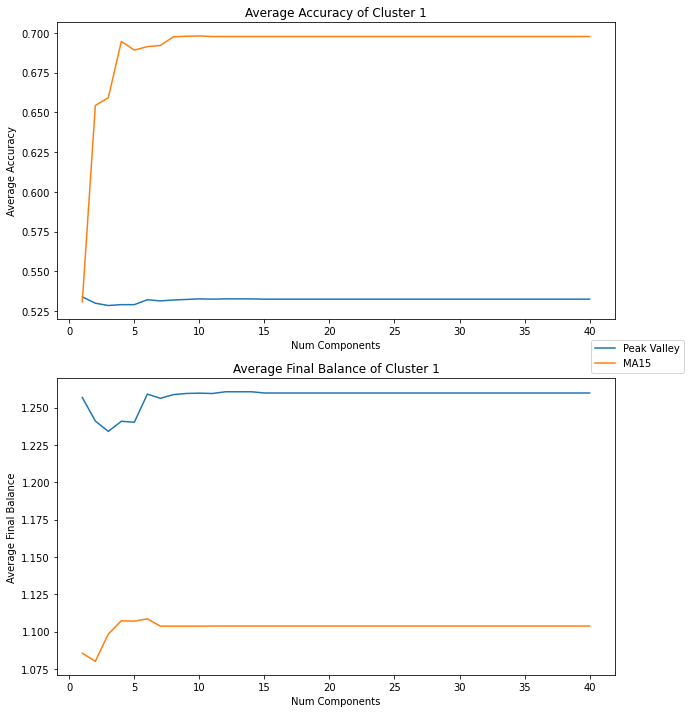

Cluster  2
Peak Comp: 1 , Final Balance: 1.3903221861420851
MA15 Comp: 2 , Final Balance: 1.2169501115988746


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


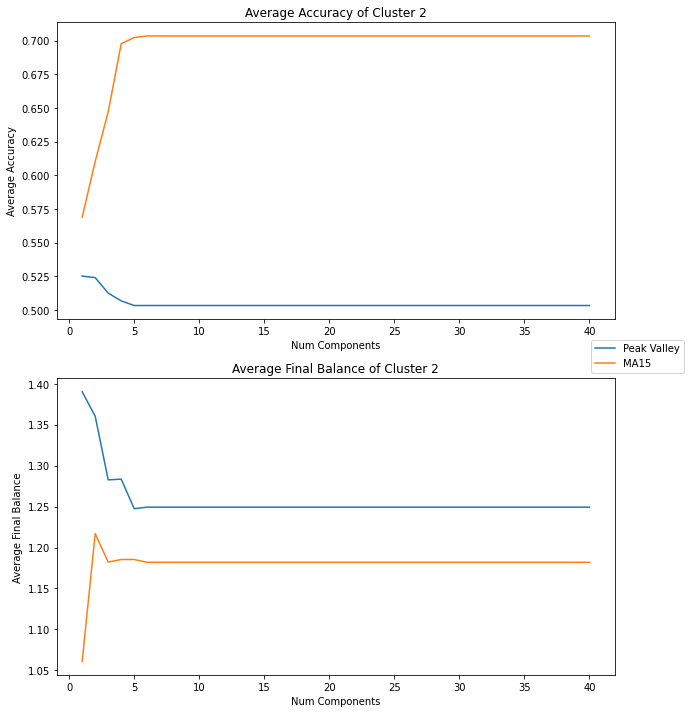

Cluster  3
Peak Comp: 2 , Final Balance: 1.2001530266143112
MA15 Comp: 2 , Final Balance: 1.032048457686049


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


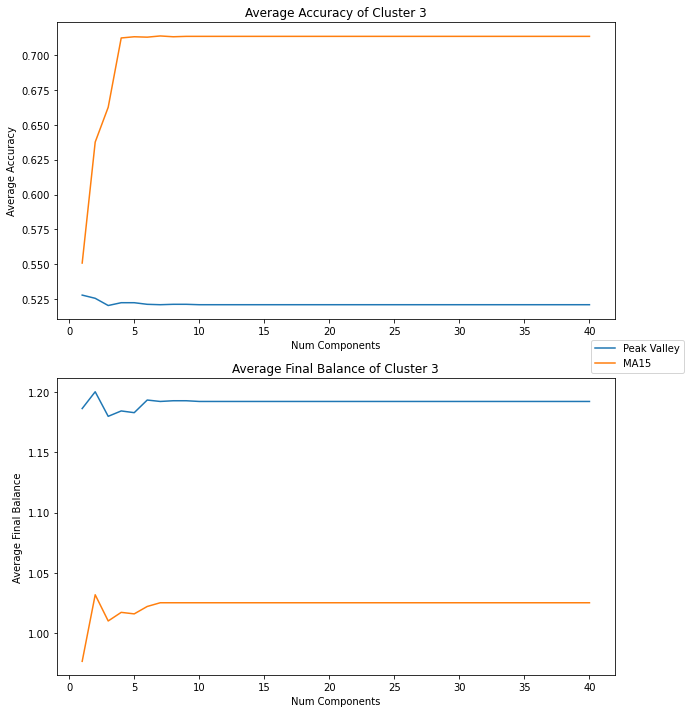

Cluster  4
Peak Comp: 2 , Final Balance: 1.1852874716026272
MA15 Comp: 4 , Final Balance: 1.0821617533579442


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


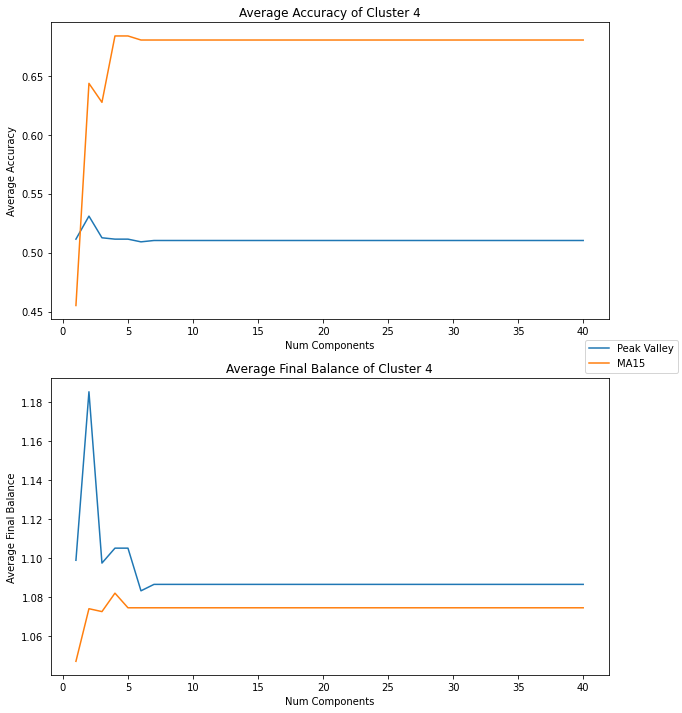

Cluster  5
Peak Comp: 3 , Final Balance: 1.0799508835140943
MA15 Comp: 5 , Final Balance: 1.0762996723819205


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


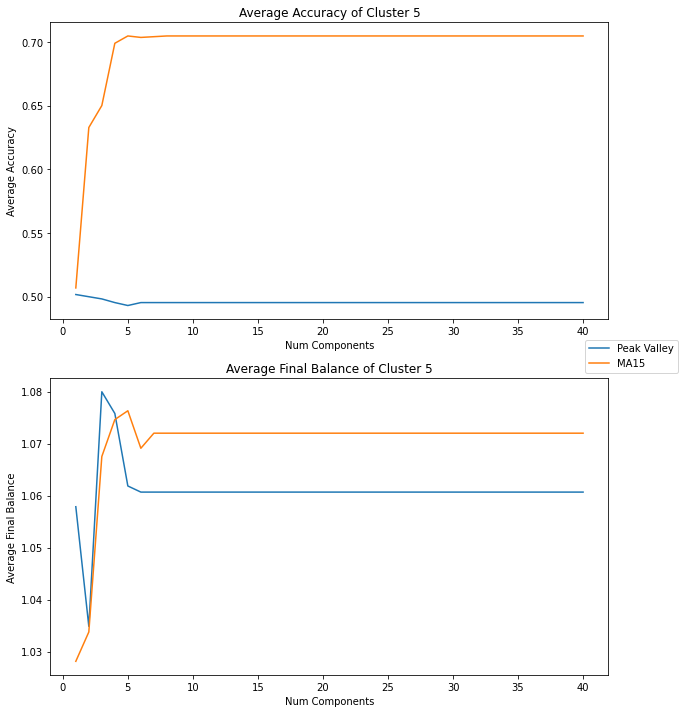

Cluster  6
Peak Comp: 8 , Final Balance: 1.0546787626841287
MA15 Comp: 3 , Final Balance: 1.2330708172477998


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


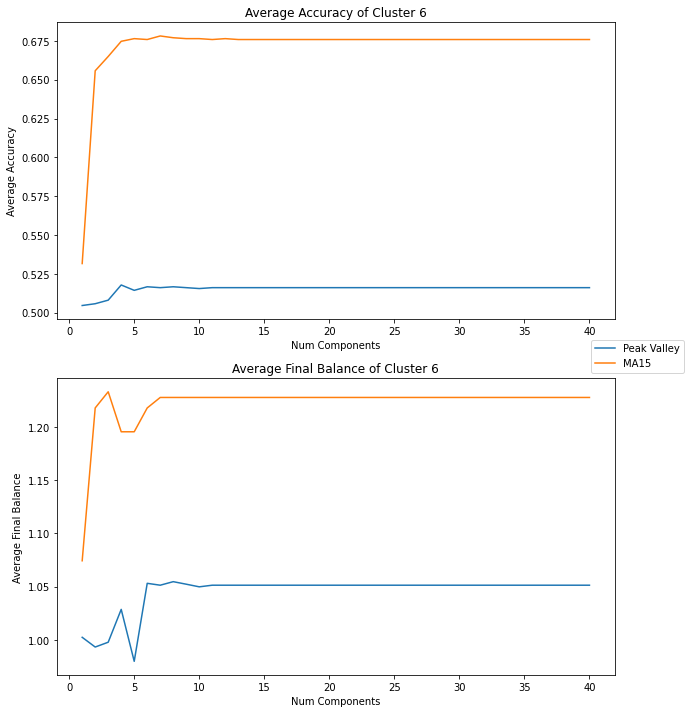

In [22]:
comp_list = list(range(1, 41))
for c in range(len(clusters)):
  print("Cluster ", c+1)
  stocks = clusters[c]
  peak_avg_accs = []
  peak_avg_final_bal = []
  MA15_avg_accs = []
  MA15_avg_final_bal = []
  for i in comp_list:
    accuracy = np.zeros((len(stocks), 2))
    final_bal = np.zeros((len(stocks), 2))
    ind = 0

    pca = PCA(n_components=i)
    train_data_pca = pca.fit_transform(cluster_train_data[c])    
    linSVC_peak = LinearSVC()
    model_peak = linSVC_peak.fit(train_data_pca, cluster_train_labels_peak[c], sample_weight=1e-4)
    linSVC_MA15 = LinearSVC()
    model_MA15 = linSVC_MA15.fit(train_data_pca, cluster_train_labels_MA15[c], sample_weight=1e-4)

    for symbol in stocks:
      # Get stock test data features and labels
      test_dates, test_vals = pull_data_from_csv(symbol, "test_data")
      test_data = get_features_data(test_vals)
      test_labels_peak, _ = daily_peak_valley_labels(test_vals)
      test_labels_MA15, _ = MA15_trend_analysis_labels(test_vals)
      test_data[np.isnan(test_data)] = 0

      # Apply PCA to data
      test_data_pca = pca.transform(test_data)

      # Train with Gaussian NB
      preds_peak = linSVC_peak.predict(test_data_pca)
      acc_peak = metrics.accuracy_score(test_labels_peak, preds_peak)
      acct_peak = simulate(test_vals, preds_peak)

      preds_MA15 = linSVC_MA15.predict(test_data_pca)
      acc_MA15 = metrics.accuracy_score(test_labels_MA15, preds_MA15)
      acct_MA15 = simulate(test_vals, preds_MA15)

      # Update variables
      accuracy[ind,0] = acc_peak
      accuracy[ind,1] = acc_MA15
      final_bal[ind, 0] = acct_peak[-1]
      final_bal[ind, 1] = acct_MA15[-1]
      ind += 1

    avg_accuracy = np.mean(accuracy, axis=0)
    avg_final_bal = np.mean(final_bal, axis=0)
    peak_avg_accs.append(avg_accuracy[0])
    peak_avg_final_bal.append(avg_final_bal[0])
    MA15_avg_accs.append(avg_accuracy[1])
    MA15_avg_final_bal.append(avg_final_bal[1])

  print("Peak Comp:", np.argmax(peak_avg_final_bal)+1, ", Final Balance:", np.max(peak_avg_final_bal))
  print("MA15 Comp:", np.argmax(MA15_avg_final_bal)+1, ", Final Balance:", np.max(MA15_avg_final_bal))

  fig, (ax_acc, ax_final_bal) = plt.subplots(2,1, figsize=(10,12))
  ax_acc.plot(comp_list, peak_avg_accs, label="Peak Valley")
  ax_acc.plot(comp_list, MA15_avg_accs, label="MA15")
  ax_acc.set_title("Average Accuracy of Cluster {}".format(c+1))
  ax_acc.set_xlabel("Num Components")
  ax_acc.set_ylabel("Average Accuracy")

  ax_final_bal.plot(comp_list, peak_avg_final_bal, label="Peak Valley")
  ax_final_bal.plot(comp_list, MA15_avg_final_bal, label="MA15")
  ax_final_bal.set_title("Average Final Balance of Cluster {}".format(c+1))
  ax_final_bal.set_xlabel("Num Components")
  ax_final_bal.set_ylabel("Average Final Balance")
  fig.legend([ax_acc, ax_final_bal], labels=["Peak Valley", "MA15"], loc="center right")
  plt.show()

Optimal PCA

Cluster  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


Higher Peak Accuracy Count:  0
Higher MA15 Accuracy Count:  19
Higher Peak Final Balance Count:  14
Higher MA15 Final Balance Count:  5
Avg Accuracy: [Peak, MA15] =  [0.53266788 0.69800363]
Avg Final Balance: [Peak, MA15, Buy-hold] =  [1.25963252 1.10360499 1.23951547]


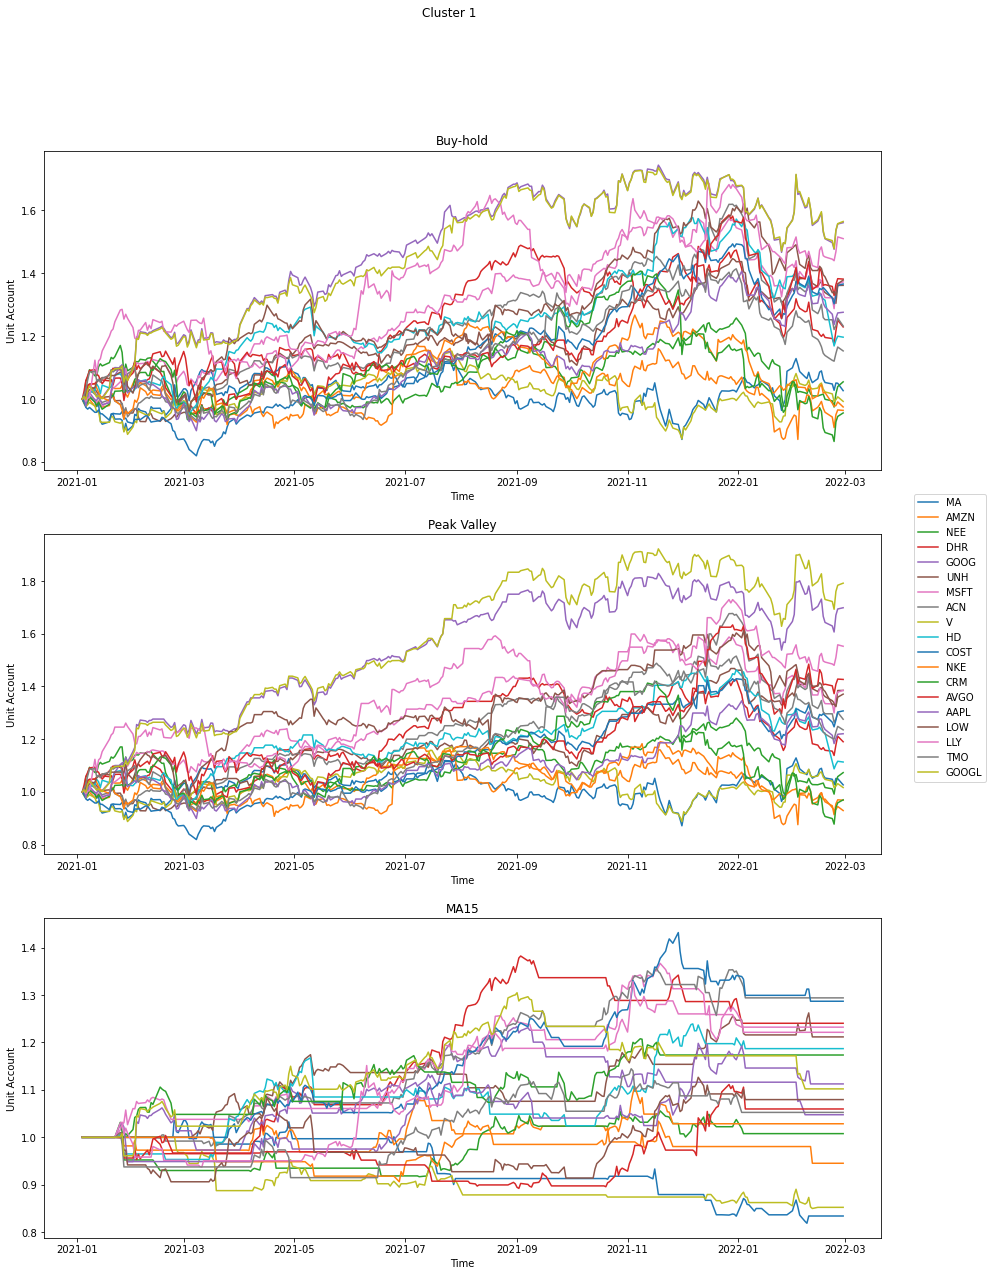

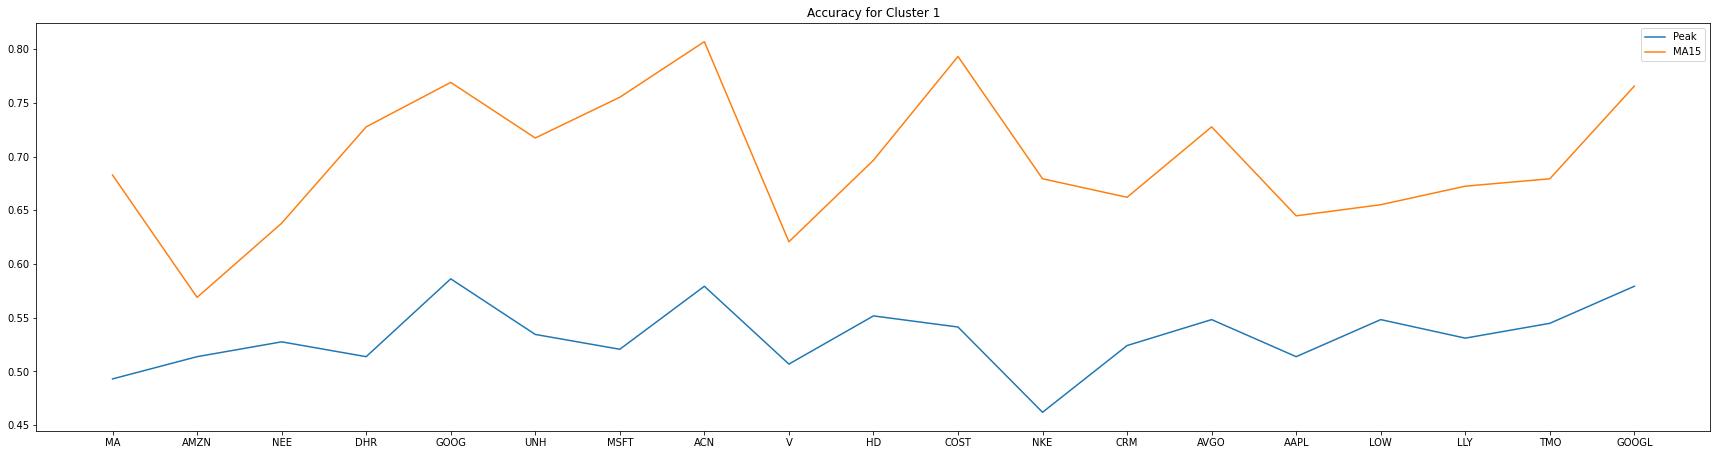

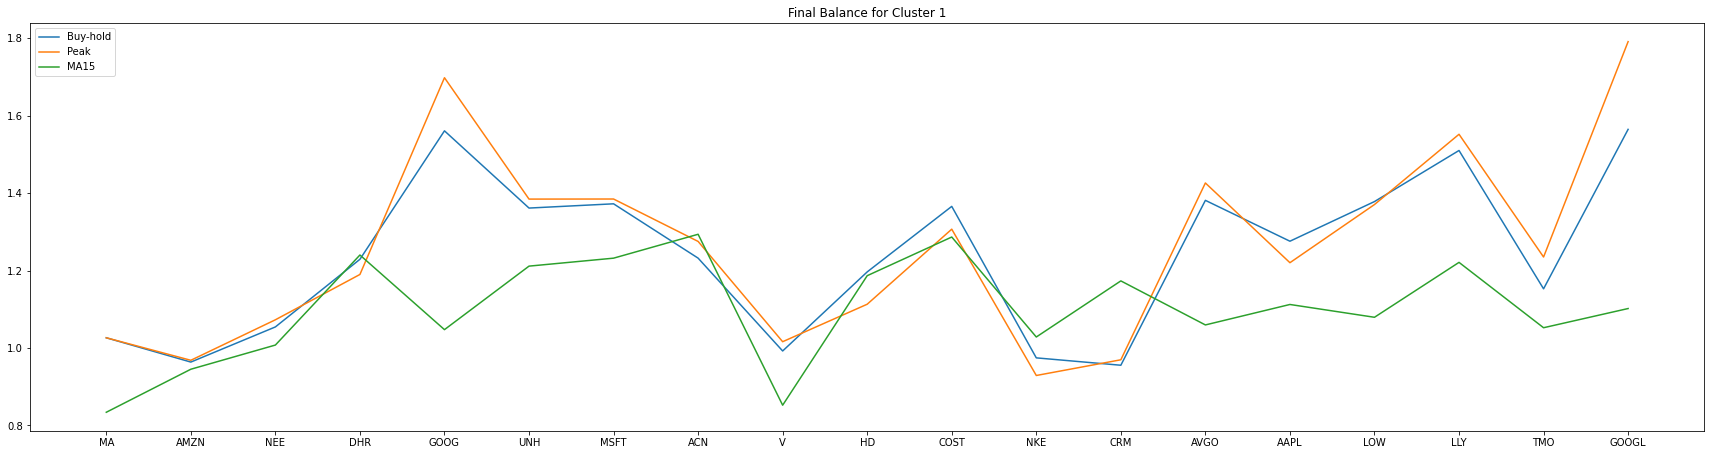

Cluster  2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


Higher Peak Accuracy Count:  0
Higher MA15 Accuracy Count:  3
Higher Peak Final Balance Count:  2
Higher MA15 Final Balance Count:  1
Avg Accuracy: [Peak, MA15] =  [0.50344828 0.70344828]
Avg Final Balance: [Peak, MA15, Buy-hold] =  [1.24931768 1.18191498 1.55885621]


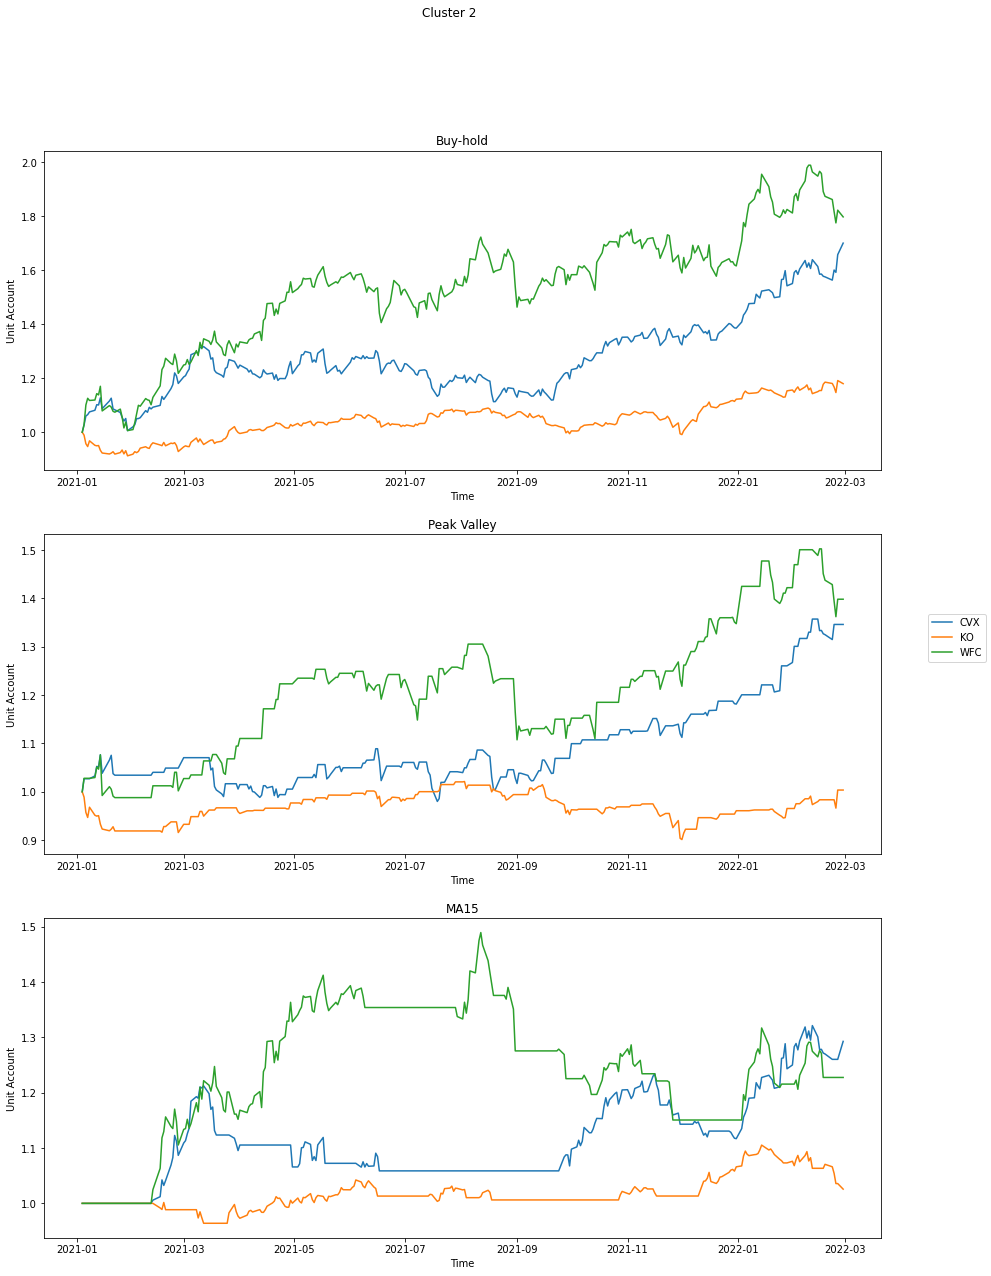

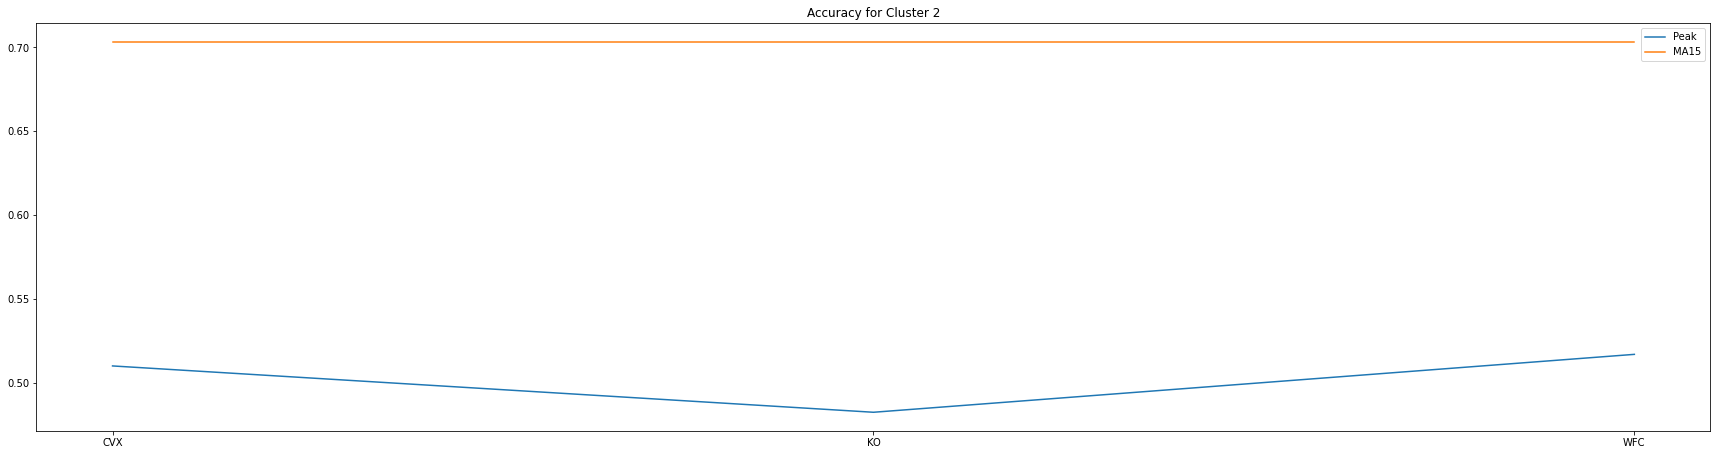

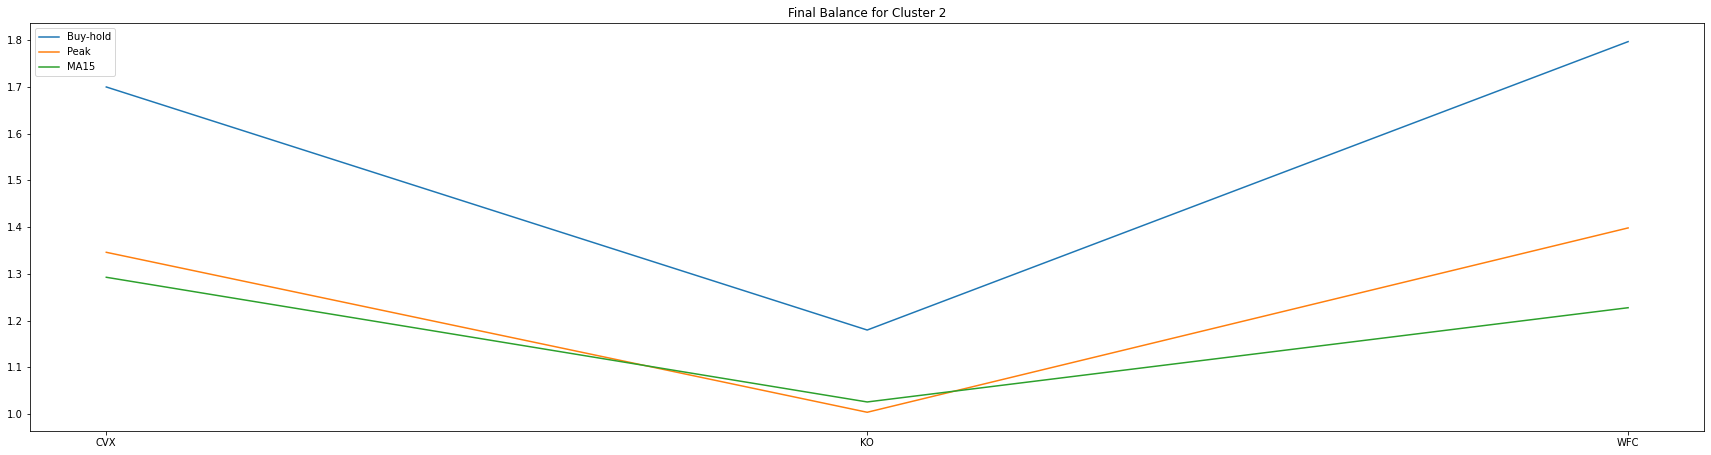

Cluster  3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


Higher Peak Accuracy Count:  0
Higher MA15 Accuracy Count:  12
Higher Peak Final Balance Count:  12
Higher MA15 Final Balance Count:  0
Avg Accuracy: [Peak, MA15] =  [0.52097701 0.71350575]
Avg Final Balance: [Peak, MA15, Buy-hold] =  [1.19212957 1.02541996 1.16322689]


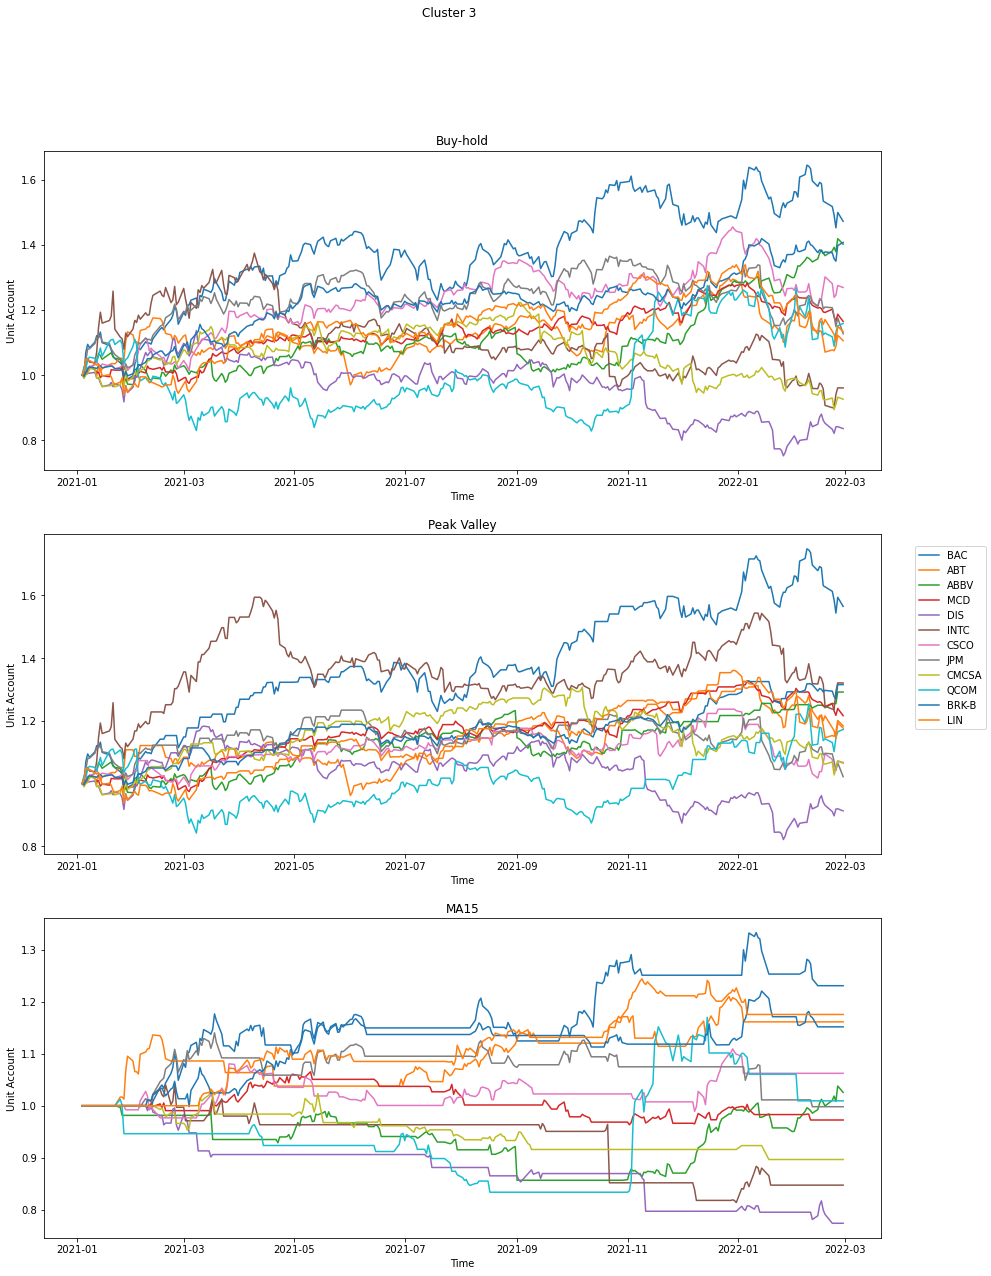

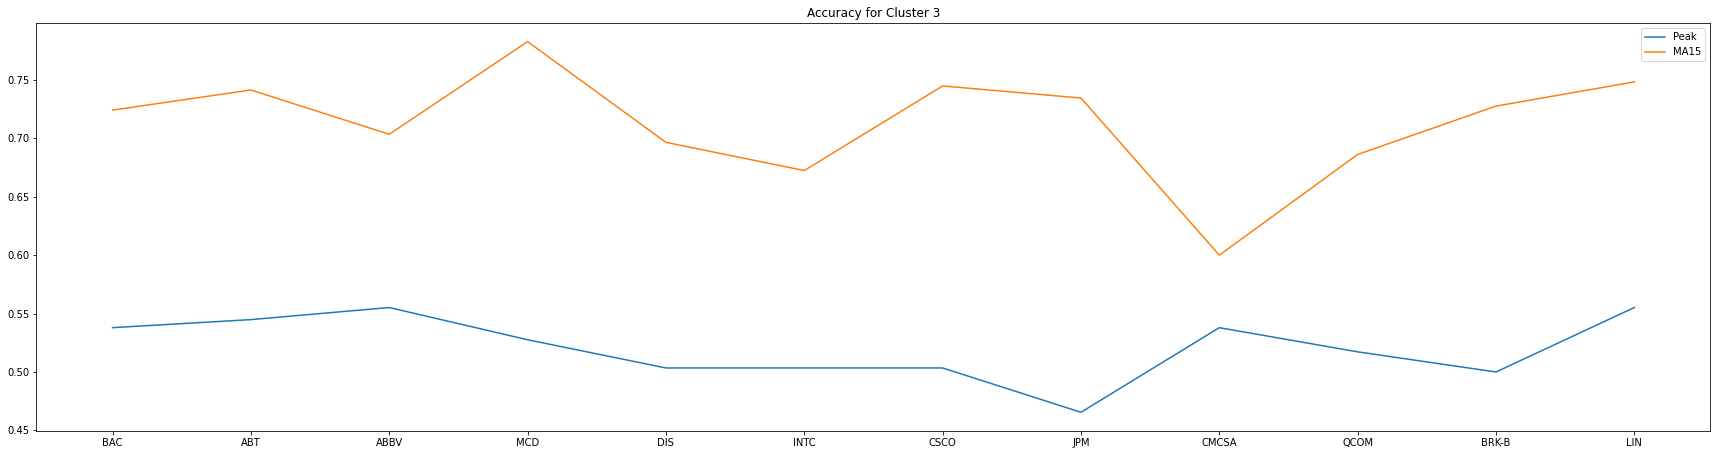

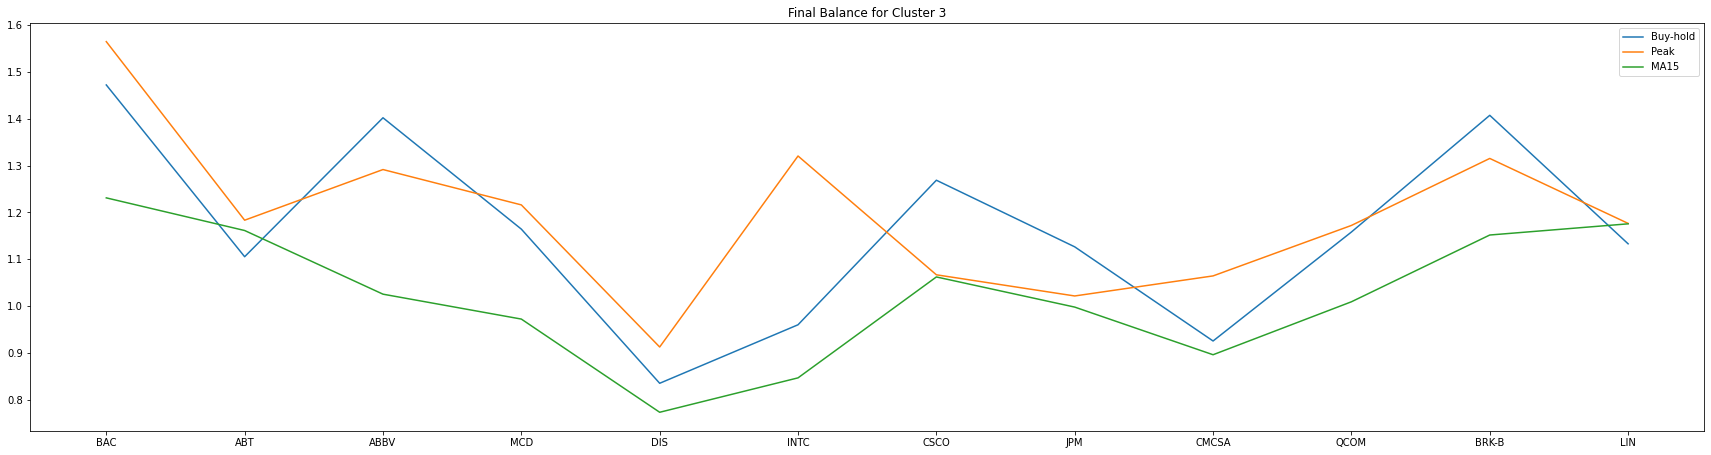

Cluster  4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


Higher Peak Accuracy Count:  0
Higher MA15 Accuracy Count:  3
Higher Peak Final Balance Count:  3
Higher MA15 Final Balance Count:  0
Avg Accuracy: [Peak, MA15] =  [0.53103448 0.64367816]
Avg Final Balance: [Peak, MA15, Buy-hold] =  [1.18528747 1.07419927 1.20210187]


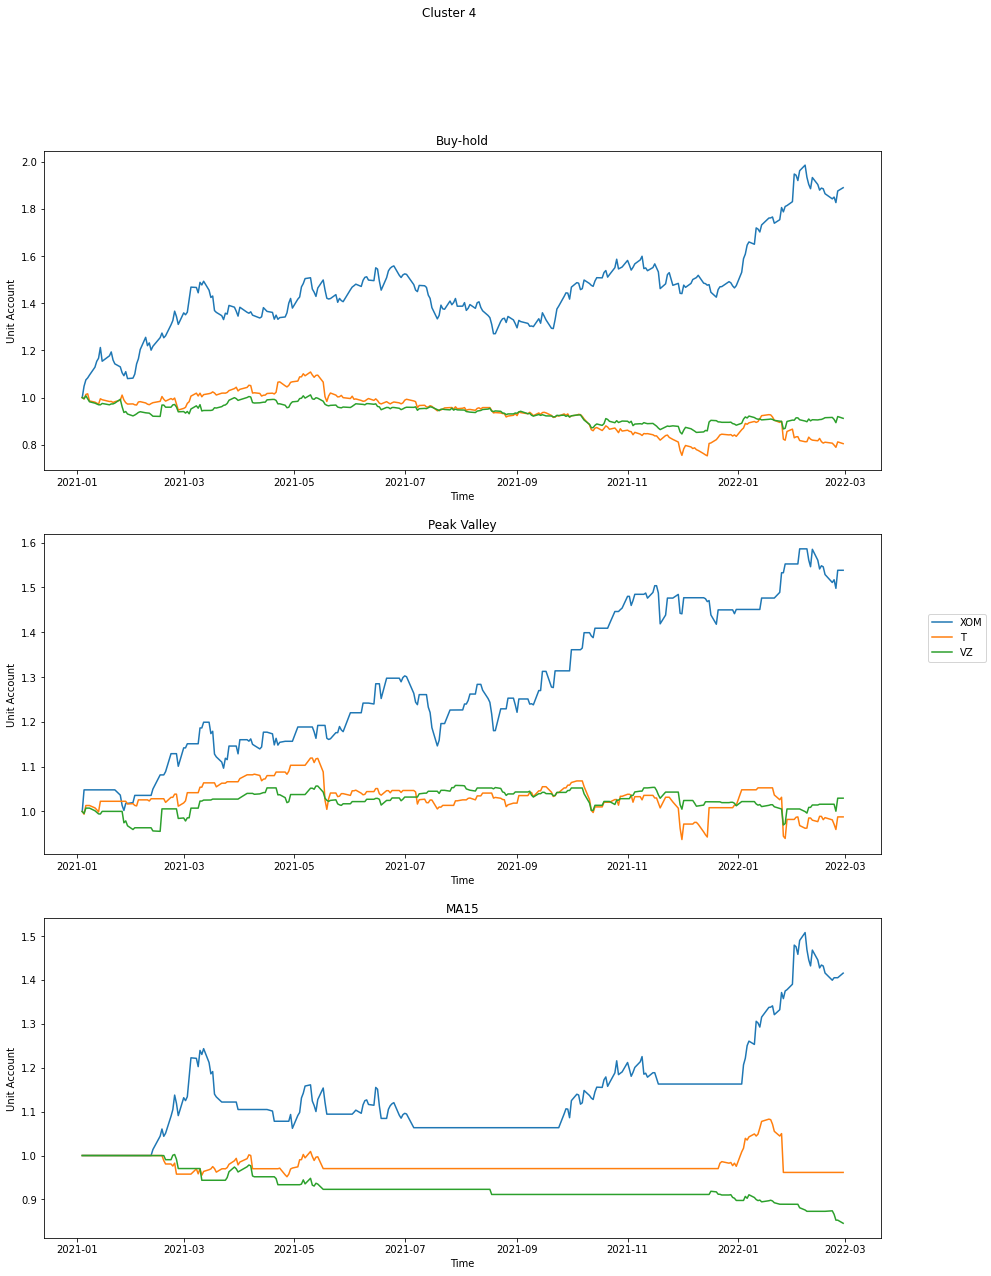

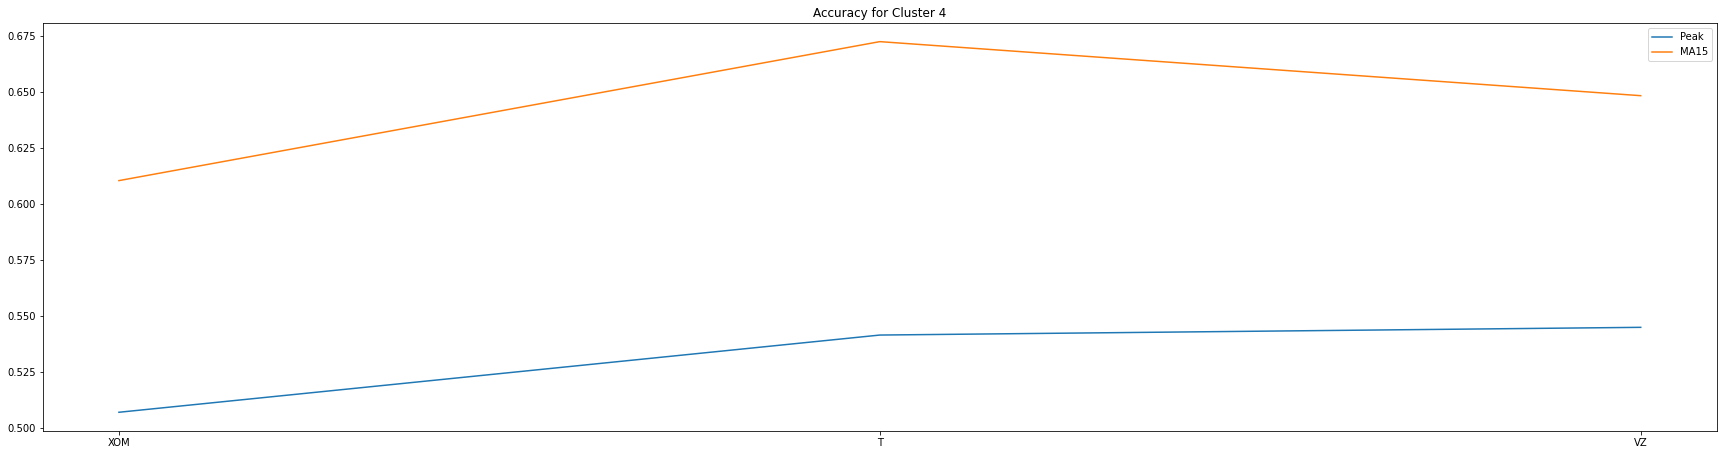

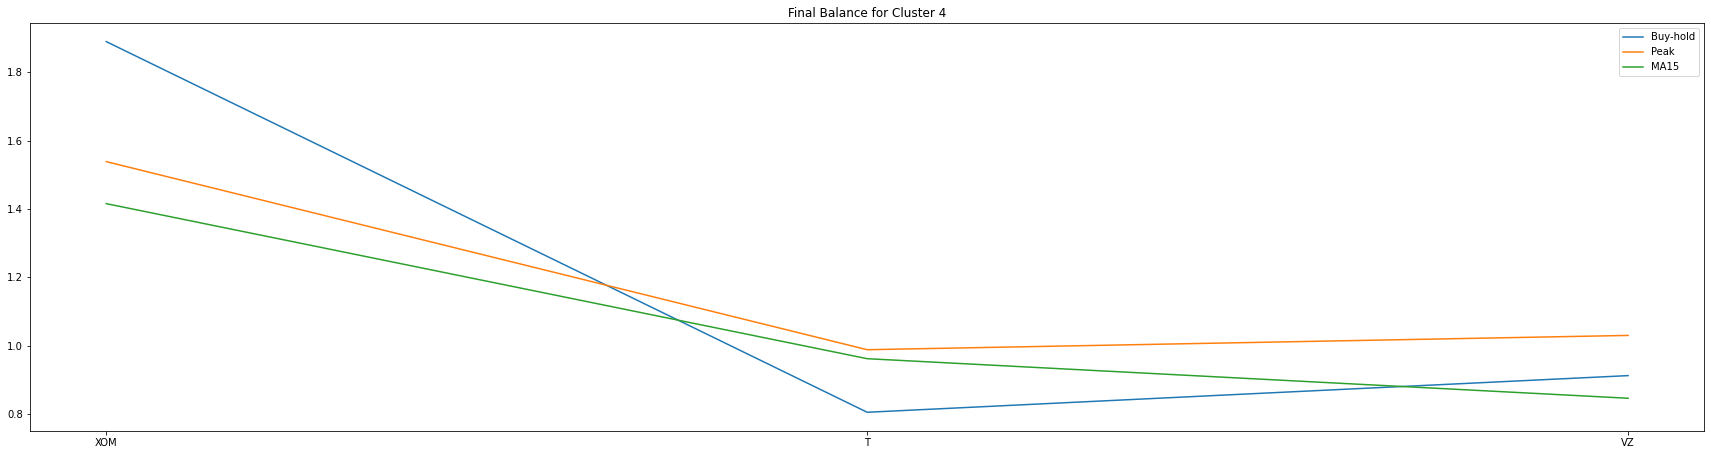

Cluster  5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


Higher Peak Accuracy Count:  0
Higher MA15 Accuracy Count:  6
Higher Peak Final Balance Count:  5
Higher MA15 Final Balance Count:  1
Avg Accuracy: [Peak, MA15] =  [0.49827586 0.65      ]
Avg Final Balance: [Peak, MA15, Buy-hold] =  [1.07995088 1.0675082  1.08442302]


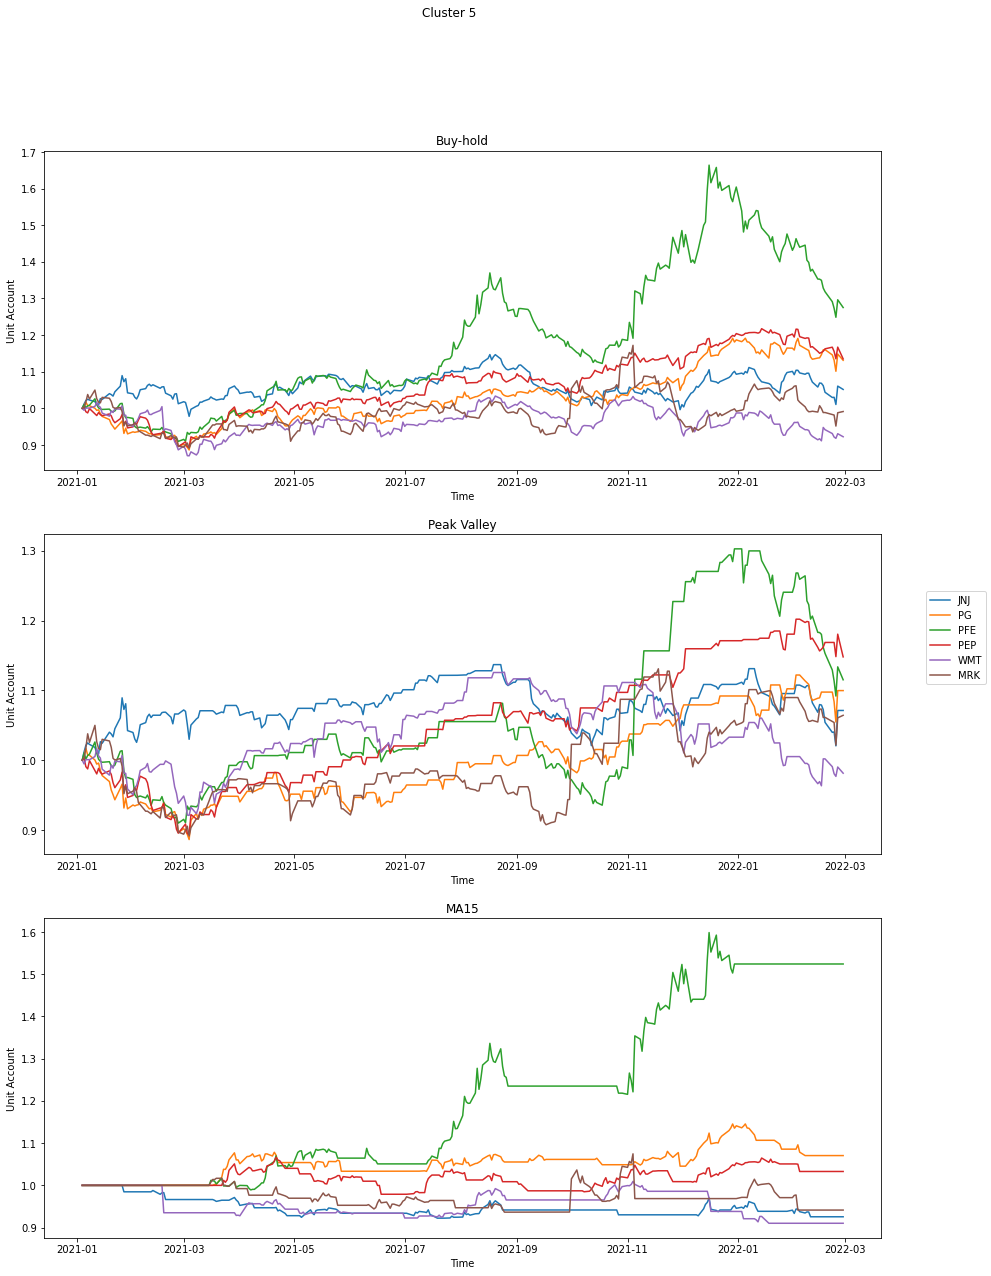

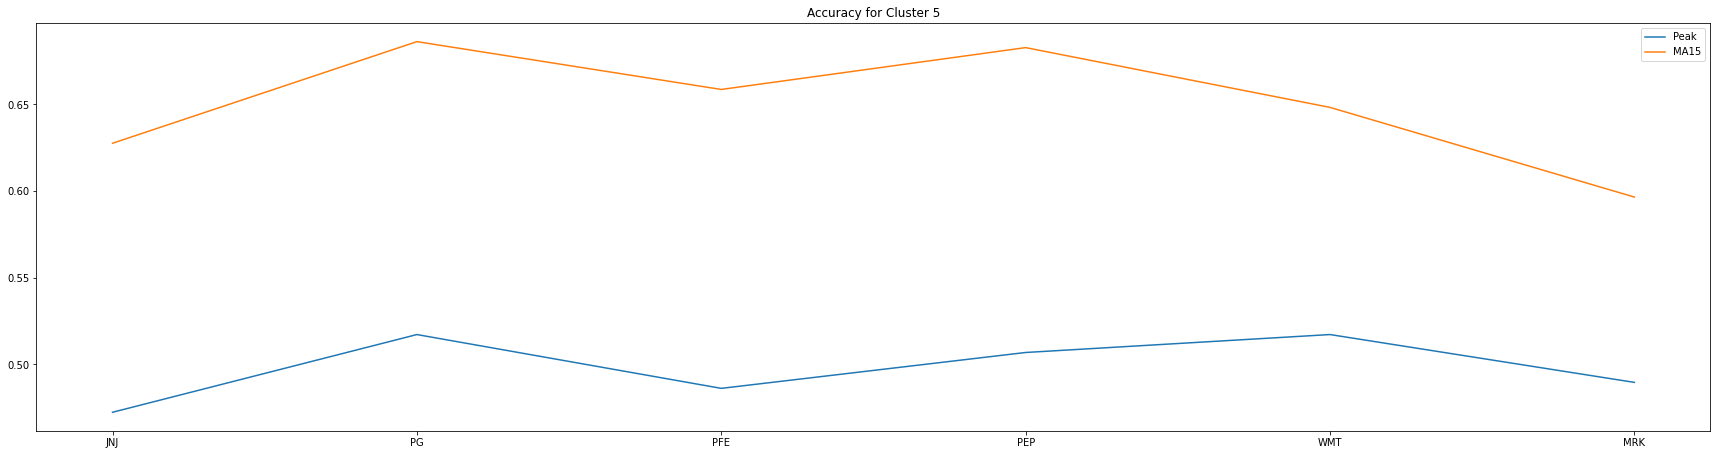

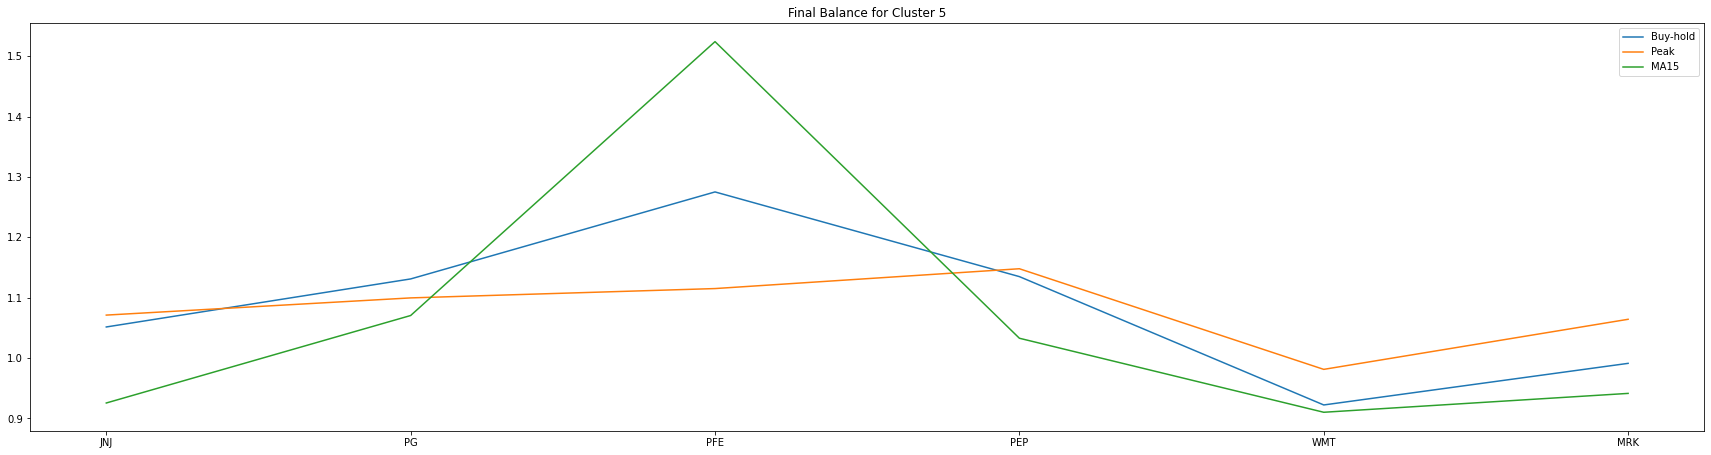

Cluster  6


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


Higher Peak Accuracy Count:  0
Higher MA15 Accuracy Count:  6
Higher Peak Final Balance Count:  2
Higher MA15 Final Balance Count:  4
Avg Accuracy: [Peak, MA15] =  [0.51609195 0.67586207]
Avg Final Balance: [Peak, MA15, Buy-hold] =  [1.05135471 1.22772609 1.13855429]


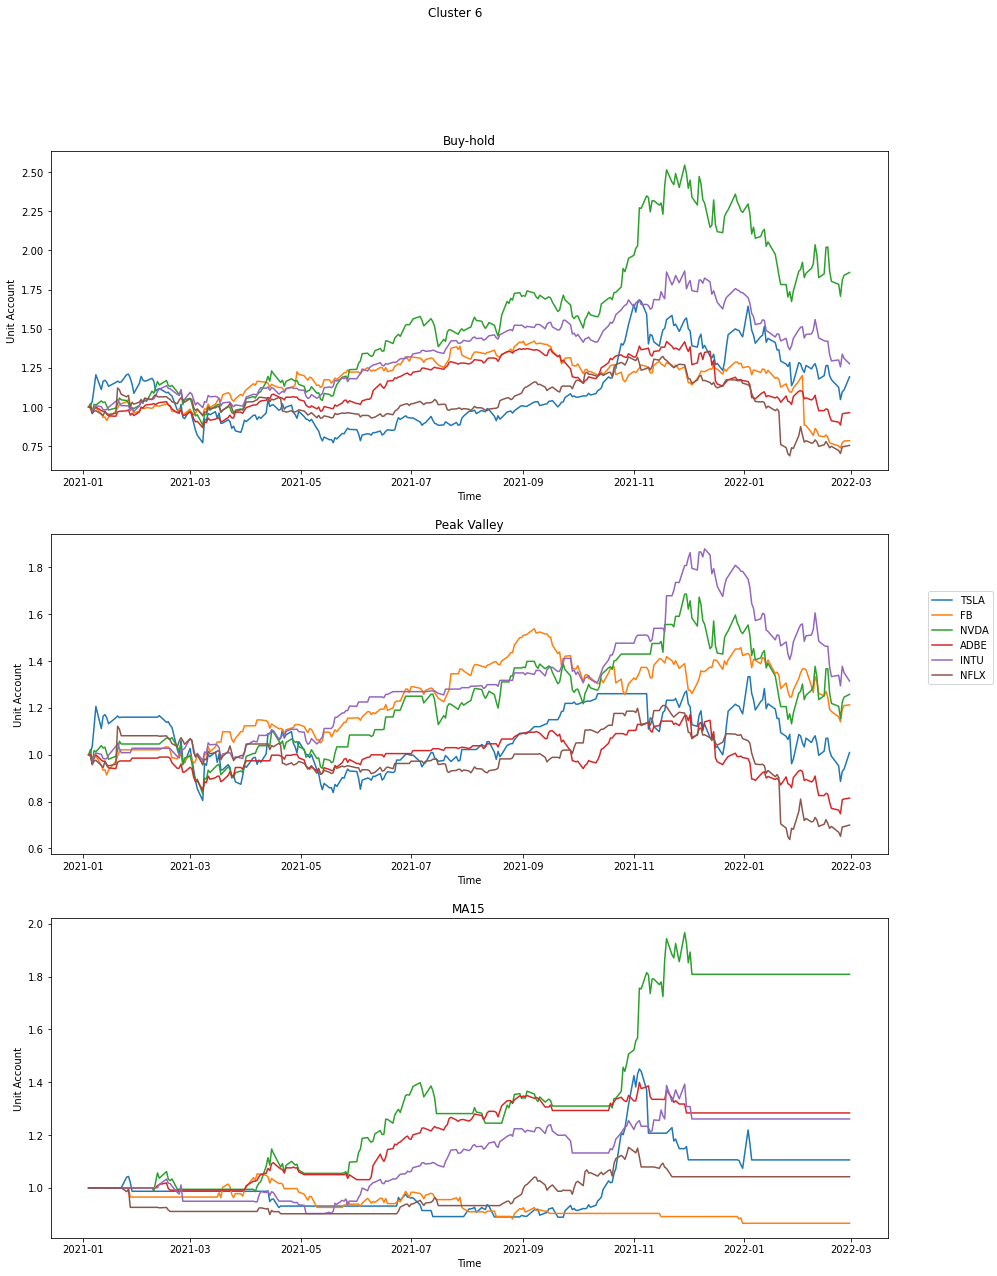

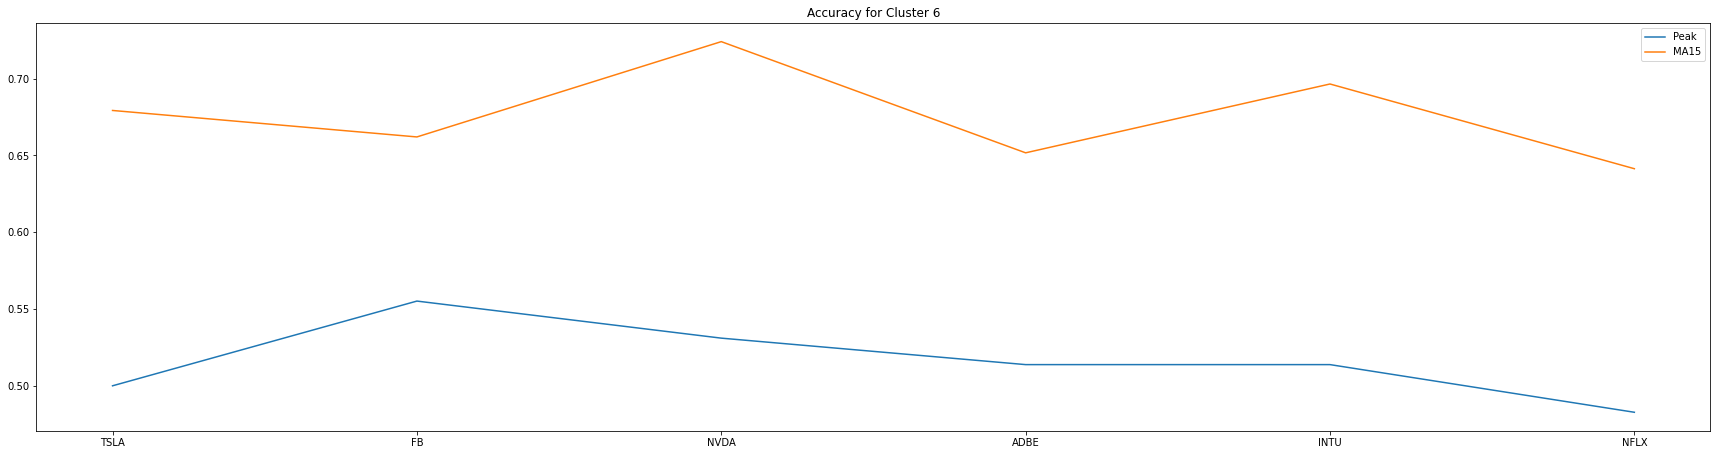

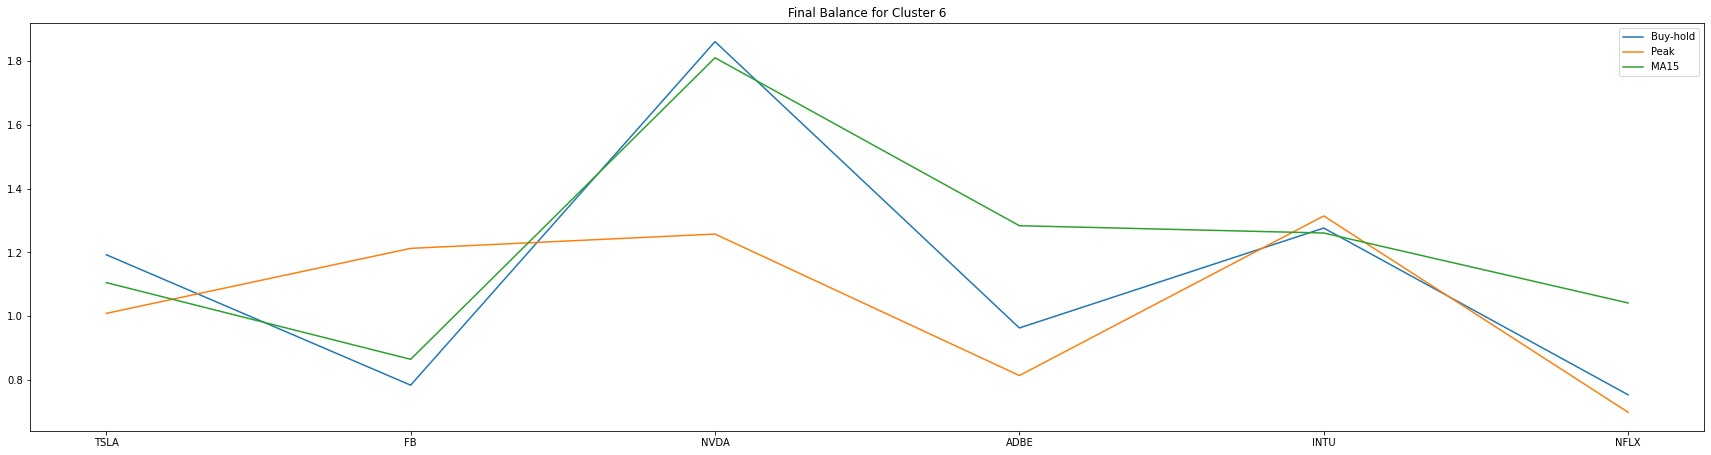

In [23]:
pca_comp_list = [10, 21, 11, 2, 3, 18]
for i in range(len(clusters)):
    print("Cluster ", i+1)
    symbols = clusters[i]
    accuracy = np.zeros((len(symbols), 2))
    final_bal = np.zeros((len(symbols), 3))
    acc_peak_cnt = 0
    acc_MA15_cnt = 0
    acct_peak_cnt = 0
    acct_MA15_cnt = 0
    ind = 0
    fig, (axB, axP, axM) = plt.subplots(3,1, figsize=(15,20))
    fig.suptitle("Cluster {}".format(i+1))
    axB.set_title("Buy-hold")
    axB.set_xlabel("Time")
    axB.set_ylabel("Unit Account")
    axP.set_title("Peak Valley")
    axP.set_xlabel("Time")
    axP.set_ylabel("Unit Account")
    axM.set_title("MA15")
    axM.set_xlabel("Time")
    axM.set_ylabel("Unit Account")

    pca = PCA(n_components=pca_comp_list[i])
    train_data_pca = pca.fit_transform(cluster_train_data[i])    
    linSVC_peak = LinearSVC()
    model_peak = linSVC_peak.fit(train_data_pca, cluster_train_labels_peak[i], sample_weight=1e-4)
    linSVC_MA15 = LinearSVC()
    model_MA15 = linSVC_MA15.fit(train_data_pca, cluster_train_labels_MA15[i], sample_weight=1e-4)

    for symbol in symbols:
        # Get stock test data features and labels
        test_dates, test_vals = pull_data_from_csv(symbol, "test_data")
        test_data = get_features_data(test_vals)
        test_labels_peak, _ = daily_peak_valley_labels(test_vals)
        test_labels_MA15, _ = MA15_trend_analysis_labels(test_vals)
        test_data[np.isnan(test_data)] = 0

        # Buy-hold
        buy_hold = np.ones((len(test_labels_peak),))
        buy_hold_acct = simulate(test_vals, buy_hold)
        axB.plot(test_dates, buy_hold_acct, label=symbol)

        # Apply PCA to data
        test_data_pca = pca.transform(test_data)

        # Train with Gaussian NB
        preds_peak = linSVC_peak.predict(test_data_pca)
        acc_peak = metrics.accuracy_score(test_labels_peak, preds_peak)
        acct_peak = simulate(test_vals, preds_peak)

        preds_MA15 = linSVC_MA15.predict(test_data_pca)
        acc_MA15 = metrics.accuracy_score(test_labels_MA15, preds_MA15)
        acct_MA15 = simulate(test_vals, preds_MA15)

        # Plot Account
        axP.plot(test_dates, acct_peak, label=symbol)
        axM.plot(test_dates, acct_MA15, label=symbol)

        # Update variables
        accuracy[ind,0] = acc_peak
        accuracy[ind,1] = acc_MA15
        final_bal[ind, 0] = acct_peak[-1]
        final_bal[ind, 1] = acct_MA15[-1]
        final_bal[ind, 2] = buy_hold_acct[-1]
        ind += 1
        acc_peak_cnt += acc_peak > acc_MA15
        acc_MA15_cnt += acc_MA15 > acc_peak
        acct_peak_cnt += acct_peak[-1] > acct_MA15[-1]
        acct_MA15_cnt += acct_MA15[-1] > acct_peak[-1]

    fig.legend([axB, axP, axM], labels=symbols, loc="center right")
    print("Higher Peak Accuracy Count: ", acc_peak_cnt)
    print("Higher MA15 Accuracy Count: ", acc_MA15_cnt)
    print("Higher Peak Final Balance Count: ", acct_peak_cnt)
    print("Higher MA15 Final Balance Count: ", acct_MA15_cnt)
    print("Avg Accuracy: [Peak, MA15] = ", np.mean(accuracy, axis=0))
    print("Avg Final Balance: [Peak, MA15, Buy-hold] = ", np.mean(final_bal, axis=0))
    plt.figure(figsize=(30,7.5))
    plt.plot(symbols, accuracy[:,0], label='Peak')
    plt.plot(symbols, accuracy[:,1], label='MA15')
    plt.legend()
    plt.title("Accuracy for Cluster {}".format(i+1))
    plt.show()
    plt.figure(figsize=(30,7.5))
    plt.plot(symbols, final_bal[:,2], label='Buy-hold')
    plt.plot(symbols, final_bal[:,0], label='Peak')
    plt.plot(symbols, final_bal[:,1], label='MA15')
    plt.legend()
    plt.title("Final Balance for Cluster {}".format(i+1))
    plt.show()